Author: Jason Papale (papale47@gmail.com) <br >
Last Updated: 26JAN2022

# Introduction

The purpose of this notebook is to serve as a guide for individuals who are interested in using Python to:

1. leverage a dataset to obtain insights
2. develop and evaluate predictive models
3. quantify the business impact of any treatments which are delivered based on model outputs. 

The dataset which is used in this notebook is related to customer churn and is relatively simple and straightforward. It was obtained on Kaggle.com (open source), so as to make it more accessible. For similar reasons, this notebook was written using Google Colab, so it should work if loaded into that environment.  Of note, this notebook is intended to be used with a GPU; however, this can be changed with only minor revisions to the code. Lastly, this notebook is broken into the following 4 main sections:

1. Exploratory Data Analysis (EDA) and data transformations
2. The development and evaluation of two classification models
3. An economic framework which aids in translating model performance into expected business impact, as well as in identifying the optimal classification threshold
4. A simulated experiment which quantifies the impact of a model-driven treatment

# Imports and Setup

In [2]:
%%capture
!pip3 install ipympl
!pip install bayesian-optimization

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import datetime as dt
import pickle
import warnings
import random
import zipfile

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score, roc_curve, precision_score, precision_recall_curve, r2_score, mean_absolute_error, make_scorer, auc
from sklearn.metrics import mean_squared_error as MSE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pylab import meshgrid, cm, clabel, colorbar, contour

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, XGBRegressor, plot_tree
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as st

from bayes_opt import BayesianOptimization

from google.colab import drive, output


In [4]:
# Pulling the data into Colab
# The Kaggle page where the dataset was originally obtained can be found here: https://www.kaggle.com/blastchar/telco-customer-churn
!git clone https://github.com/papale47/papale47.github.io.git

Cloning into 'papale47.github.io'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 127 (delta 59), reused 8 (delta 0), pack-reused 0
Receiving objects: 100% (127/127), 4.96 MiB | 17.64 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [5]:
# Extracting the files from the zip file and placing them in a sample_data folder
with zipfile.ZipFile('papale47.github.io/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('sample_data')

# EDA and Data Transformation

## Helper Functions

In [6]:
def one_hot(df, field_to_encode, dummy_na=False, drop_original_field='Yes'):

    # Get one hot encoding of columns
    HOT_ENCODINGS = pd.get_dummies(df[field_to_encode], prefix=field_to_encode, dummy_na=dummy_na)

    # Drop categorical column as it is now encoded
    if drop_original_field == 'Yes':
      df = df.drop(field_to_encode,axis = 1)

    # Join the encoded df
    df = df.join(HOT_ENCODINGS)

    return df

## Importing the Data and Basic EDA

Based on the initial EDA performed below, we can see that this dataset has just over 7k records with (at least initially) no null values.  The dataset is slightly imbalanced with respect to the outcome variable `Churn` in that ~27% of the customers have churned. Also, when we look to see what the object types are for the fields in the dataset, many are of the string object type. Most of these string fields represent categorical variables which will either be converted into a binary variable or a series of one-hot encoded variables. There is one variable, however, which we would expect to be numeric but which has been parsed as a string: `TotalCharges`. Upon further exploration, we can see that there are some values which are just whitespace. As a result, when we attempt to convert this field to numeric (providing instructions to convert any value which cannot be converted to a number to a null value), we end up with a handful of null values. Since one of the models we will end up training (XGBoost) can handle null values without an issue, we will keep these null values in the dataset for that model. However, the other model we will train, Random Forest, does not work with null values, so for that model we will end up dropping these records. There could be a case made to impute an average value for these null values; however, since we do not know why the values are null (i. e., they could be null because there actually are actually no charges or because there is legimitally missing data), we will ultimately drop these records when training and evaluating the Random Forest. Ultimately, since the number of records in question is very small, it is not assessed to have a material impact in any anaylses or modeling.

After converting the `TotalCharges` field to numeric, we then encode all binary variables to be a 1 or 0 instead of having the initial text values. Similarly, for categorical fiels which have more than just two values, we one-hot encode these fields, which has the effect of adding a column to indicate the presence of each of the possible values in the original field. Also, since all of the information for these one-hot encoded fields is contained in the newly created binary fields, the original fields which contain all of the categorical values are dropped from the dataset.

In [7]:
# Reading the data in as a Pandas dataframe
df=pd.read_csv('/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [8]:
# Viewing the first 5 records in the dataframe
df.head()

customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0  7590-VHVEG  Female              0  ...          29.85        29.85     No
1  5575-GNVDE    Male              0  ...          56.95       1889.5     No
2  3668-QPYBK    Male              0  ...          53.85       108.15    Yes
3  7795-CFOCW    Male              0  ...          42.30      1840.75     No
4  9237-HQITU  Female              0  ...          70.70       151.65    Yes

[5 rows x 21 columns]

In [9]:
# Number of records in the dataframe
len(df)

7043

In [10]:
# Number of unique customer IDs
df['customerID'].nunique()

7043

In [11]:
# Distribution of the outcome variable
df.groupby('Churn')['customerID'].count()/len(df)

Churn
No     0.73463
Yes    0.26537
Name: customerID, dtype: float64

In [12]:
# Number of records if we were to drop any records with a null value
len(df.dropna())

7043

In [13]:
# Column types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [14]:
# Getting a sense for the range of values in each field
for i in range(len(df.columns)):
  print(df.columns[i])
  print(df.iloc[:,i].unique())

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender
['Female' 'Male']
SeniorCitizen
[0 1]
Partner
['Yes' 'No']
Dependents
['No' 'Yes']
tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService
['No' 'Yes']
MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaperlessBilling
['Yes' 'No']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

In [15]:
# Seeing what the shortest string in this field is (suspecting it may be the cause for the field being parsed as string)
df['TotalCharges'].min()

' '

In [16]:
# Converting the TotalCharges field to numeric, converting any values which can't convert to numeric to a null
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [17]:
# Checking to see the minimum value now that the field is numeric
df['TotalCharges'].min()

18.8

In [18]:
# Number of records in the dataframe if we were to drop records with a null value
len(df.dropna())

7032

In [19]:
# Replacing text in binary fields to 1s and 0s
for i in range(len(df.columns)):
  values = df.iloc[:,i].unique()
  if sorted(values) == ['No', 'Yes']:
    # print(df.columns[i])
    df.iloc[:,i].replace(to_replace = 'No', value = 0, inplace=True)
    df.iloc[:,i].replace(to_replace = 'Yes', value = 1, inplace=True)
  if sorted(values) == ['Female', 'Male']:
    df.iloc[:,i].replace(to_replace = 'Female', value = 0, inplace=True)
    df.iloc[:,i].replace(to_replace = 'Male', value = 1, inplace=True)

In [20]:
# One-hot converting categorical fields with more than 2 values
CATEGORICAL_FIELDS = ['MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract',
       'PaymentMethod']

for i in CATEGORICAL_FIELDS:
  df = one_hot(df, i)

## Distribution and Correlation of the Data



Now that we have obtained an initial understanding of the dataset we are working with, as well as made some transformations to make the data more consumable from a modeling standpoint, we will now take a closer look at the distribution of each field in the dataset, as well as examine the extent to which fields are correlated. 

Some initial notable things we can see when assessing the distributions of the fields in the dataset are:
1. `Tenure` has a bimodal distribution with peaks at very new customers and very tenured customers.
2. `MonthlyCharges` also has a somewhat bimodal distribution with a large peak representing very low monthly charge amounts (i.e., \$30) and another peak (which appears fairly normally distributed) around monthly charges of \$80-$90.
3. Most customers have both phone service and internet service.  When customers do have phone service, most just have one line, and when they have internet service, most have fiber optic.
4. Most customers are on month-to-month billing.

Some initial notable things we can see when assessing the correlation matrix are:
1. Fiber optic internet service is positively correlated with `MonthlyCharges`, whereas DSL internet service is negatively correlated, indicating that the fiber optic service could be a fairly expensive option.
2. `Tenure` is fairly strongly negatively correlated with `Contract_Month-to-month`, indicating that customers on month-to-month contracts may be more prone to attrition. Conversely, `Tenure` has a somewhat strong positive correlation with two-year contracts and, to a lesser extent, with one-year contracts.
3. `Tenure` is aso positively correlated with additional services, such as technical support, streaming tv, multiple phone lines, etc.
4. `Churn` is somewhat negatively correlated with these same add-on services, as well as with `Tenure`.
5. The variable which is most strongly correlated with `Churn` is `Contract_Month-to-month`, reinforcing the association previously drawn with `Tenure`.




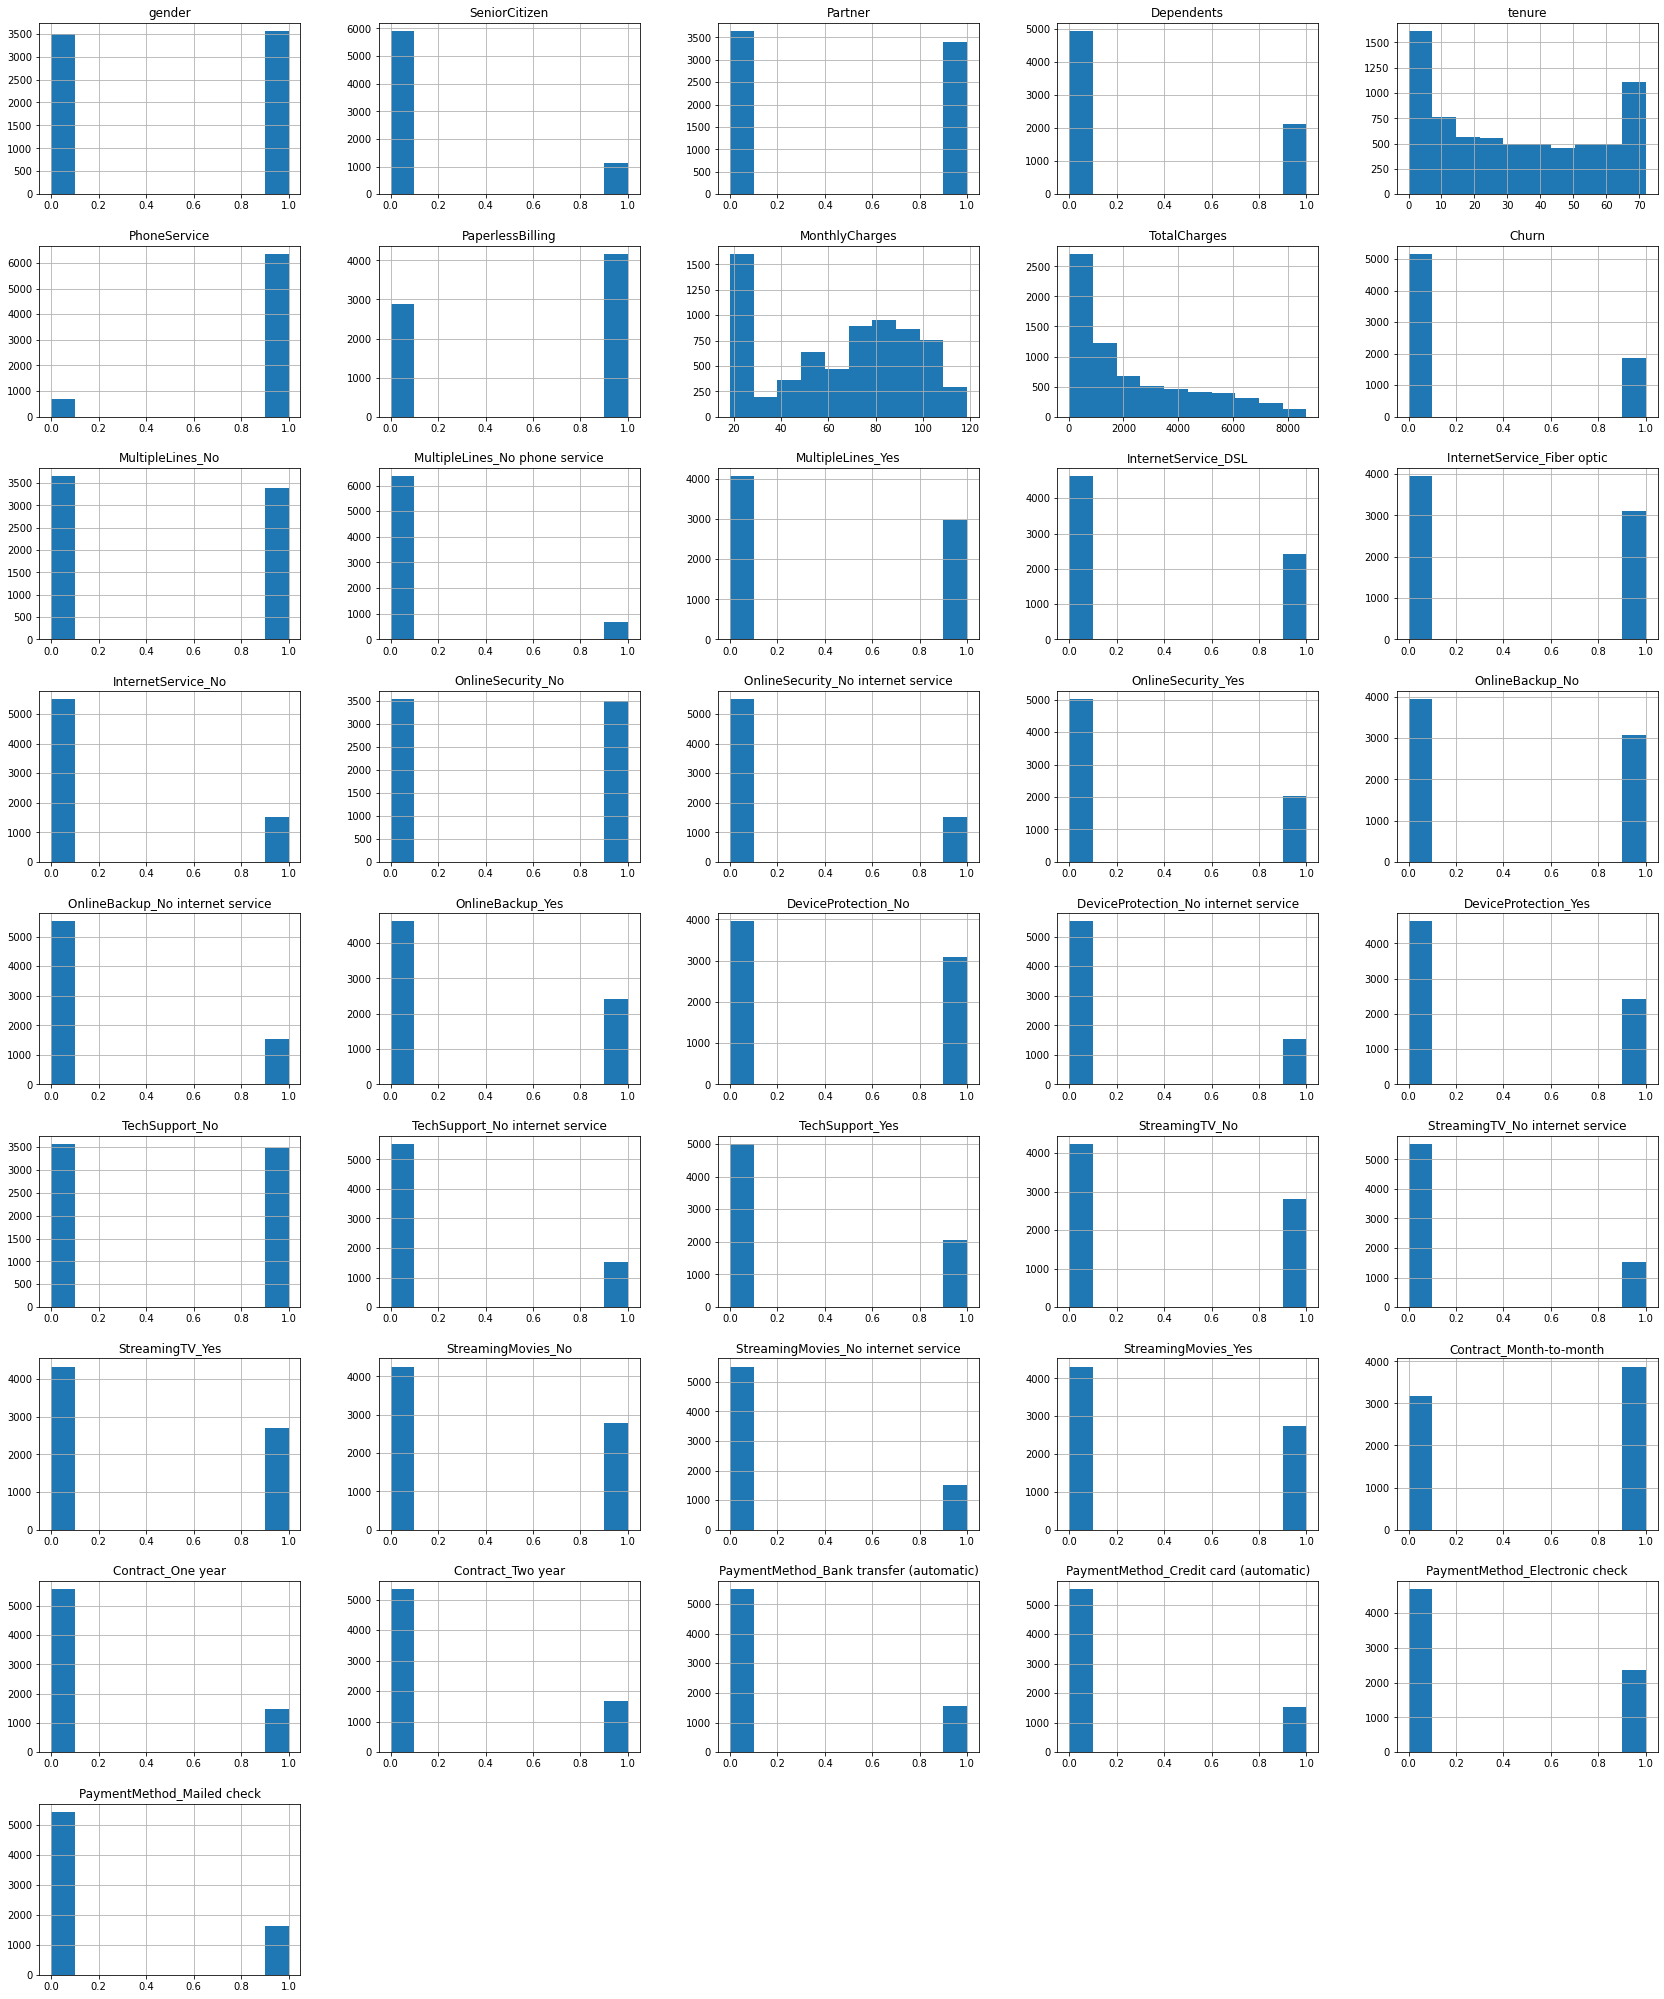

In [21]:
# Histograms of the data
df.hist(figsize=(29,40), layout=(10,5))
plt.show()

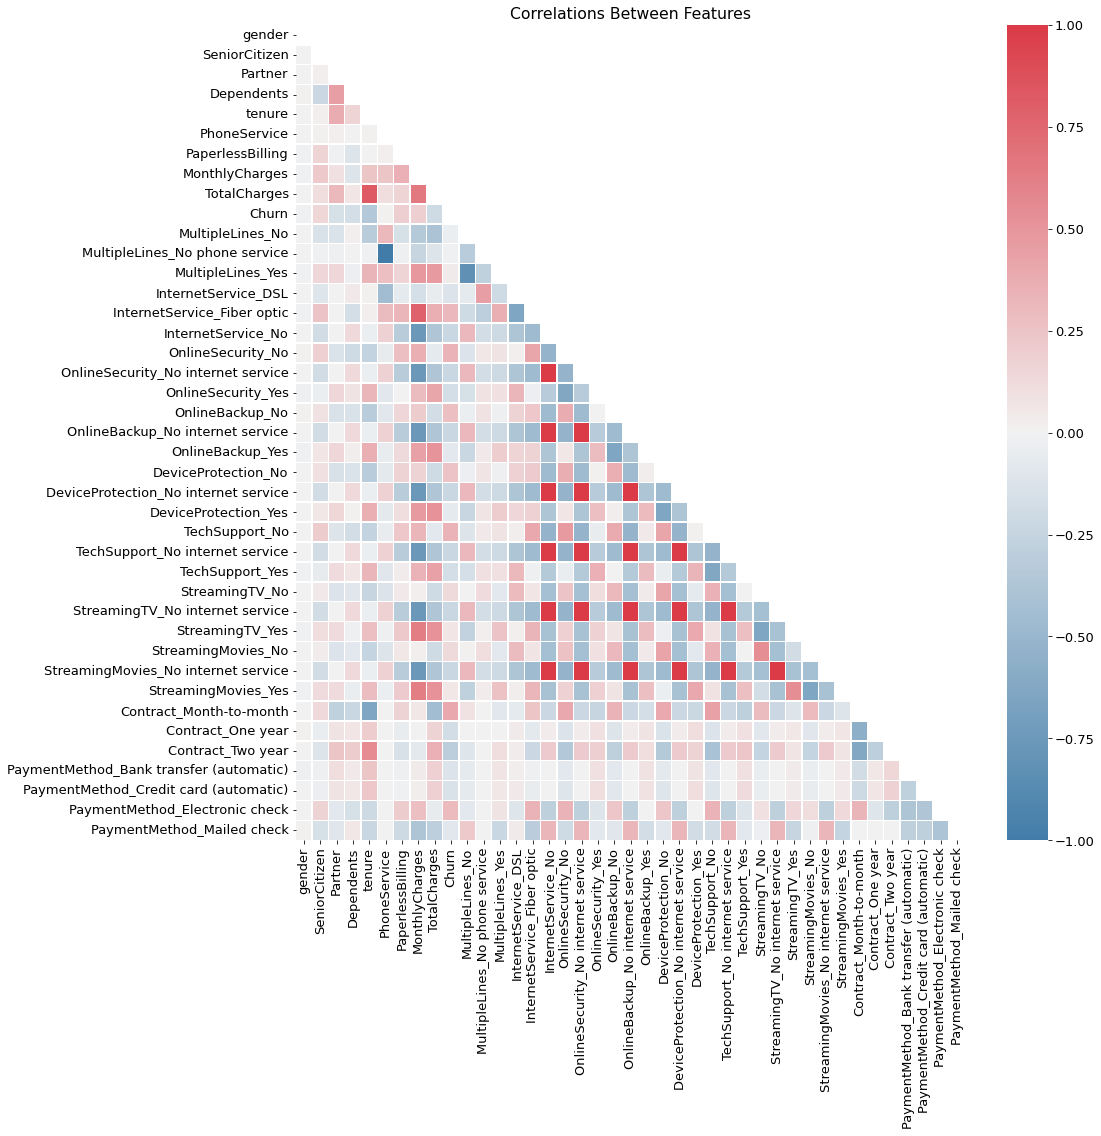

In [22]:
# Correlation matrix (heatmap)

corr = df.drop('customerID', axis=1).corr()
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(15,15))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations Between Features")
plt.show()

## Dimensionality Reduction through Principal Component Analysis (PCA)

One other technique which can be useful in identifying relationships in data  is a dimensionality reduction technique called Principal Component Analysis (PCA). With PCA, the original feature space is transformed such that new features (i.e., principal components) can be formed in a way which capture as much variance in the data as possible. As principal components are formed, they will explain progressively less variance in the data. If, however, enough of the variance in the data can be explained by the first two principal components, we are able to visualize an n-dimensional features space in a two dimensional plot and assess for any clusters or interesting patterns or relationships in the data. 

In order to perform PCA on this dataset, it was important to first standardize the dataset so that differences in the scale of the features did skew the underlying PCA processes. We also had to remove the records with the null values. Once those modifications were made, we performed an initial round of PCA to form 20 principal components. Upon assessing the principal components, we can see that the first two principal components are able to explain >50% of the variance in the entire dataset. 

We then re-performed PCA to create only two principal components and then plotted each data point (which still represents a customer) on a scatterplot. We also included a color indication to show whether or not the customer churned. We can see on this plot that there are two distinct clusters and that most of the customers who churned are towards the bottom of the larger cluster to the right. We then performed a similar plotting exercise where an indication of each of the original features is overlaid as a color on the same 2-dimensional plot. When we do this, it becomes clear that the two distinct clusters represent customers with internet service and those without.  This would indicate that across the original feature space, customers in these two clusters share similarities with each other but are materially different from customers in the other cluster. One contributing factor behind this may be attributable to the fact that many of the categorical features in the original feature space contained an indication of no internet service. Therefore, when these categorical features were one-hot encoded, it resulted in multiple  features providing the same indication of no internet service.  We can see that these one-hot encoded features are perfectly positively correlated in the correlation heatmap, and that is likely a major factor behind the creation of these two clusters.

That said, with these plots, we are also able to see how the various original features compare to the churn variable when overlaid on top of the 2-dimensional plot of the first two principal components. For example, we can see that customers who have a month-to-month contract tend to be located similarly in the 2-dimensional plot as customers who churn.

<br >

Additional references which better explain PCA: <br >
https://builtin.com/data-science/step-step-explanation-principal-component-analysis <br >
https://setosa.io/ev/principal-component-analysis/

In [23]:
CONTINUOUS_VARIABLES = []
BINARY_VARIABLES = []
for i in df.drop(['customerID', 'Churn'], axis=1).columns:
  if sorted(list(df[i].unique())) == [0, 1]:
    BINARY_VARIABLES.append(i)
  else:
    CONTINUOUS_VARIABLES.append(i)    

In [24]:
scaler = StandardScaler()
X_std = np.hstack( (df[BINARY_VARIABLES].to_numpy(), scaler.fit_transform(df[CONTINUOUS_VARIABLES])) )

In [25]:
y_array = df['Churn'].to_numpy()
y_array = y_array[~np.isnan(X_std).any(axis=1)]

In [26]:
X_std = X_std[~np.isnan(X_std).any(axis=1), :]

In [27]:
X_std.shape

(7032, 40)

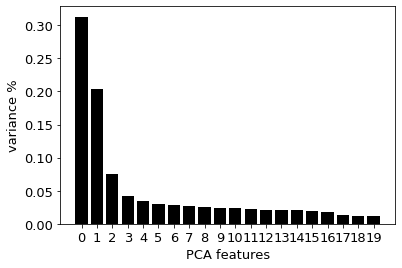

In [28]:
# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [29]:
print('The total fraction of total variance in the training data explained by the 1st principal component is', pca.explained_variance_ratio_[0])
print('The total fraction of total variance in the training data explained by the 1st principal component is', pca.explained_variance_ratio_[1])
print('The total fraction of total variance in the training data explained by the all 20 of the principal components is', sum(pca.explained_variance_ratio_))

The total fraction of total variance in the training data explained by the 1st principal component is 0.31284594322340936
The total fraction of total variance in the training data explained by the 1st principal component is 0.20320014083880858
The total fraction of total variance in the training data explained by the all 20 of the principal components is 0.9857233884105342


Text(0, 0.5, 'Principal Component 2')

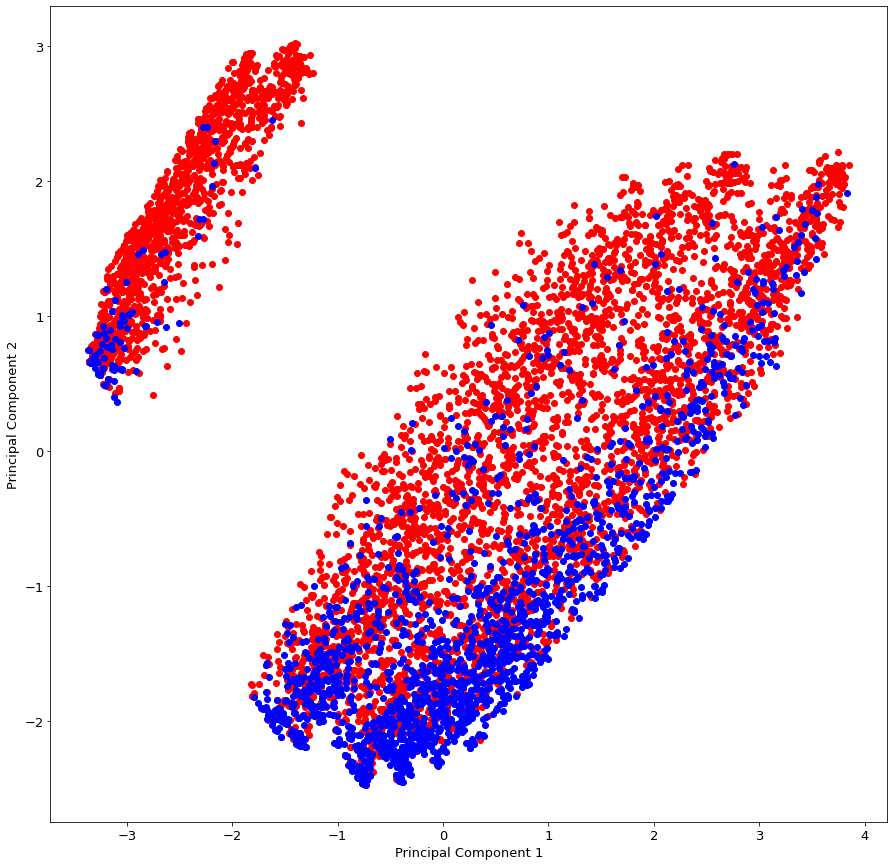

In [30]:
fig, ax = f, axs = plt.subplots(1,1,figsize=(15,15))

pca = PCA(n_components=2)
transformed = pca.fit_transform(X_std)

transformed_positive = transformed[y_array == 1]
transformed_negative = transformed[y_array == 0]

ax.scatter(transformed_negative[:,0], transformed_negative[:,1], c = 'r')
ax.scatter(transformed_positive[:,0], transformed_positive[:,1], c = 'b')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

In [35]:
PCA_EVAL_NAMES = BINARY_VARIABLES+CONTINUOUS_VARIABLES+['Churn']

In [33]:
PCA_EVAL_ARRAY = np.column_stack((X_std, y_array))
PCA_EVAL_ARRAY.shape

(7032, 41)

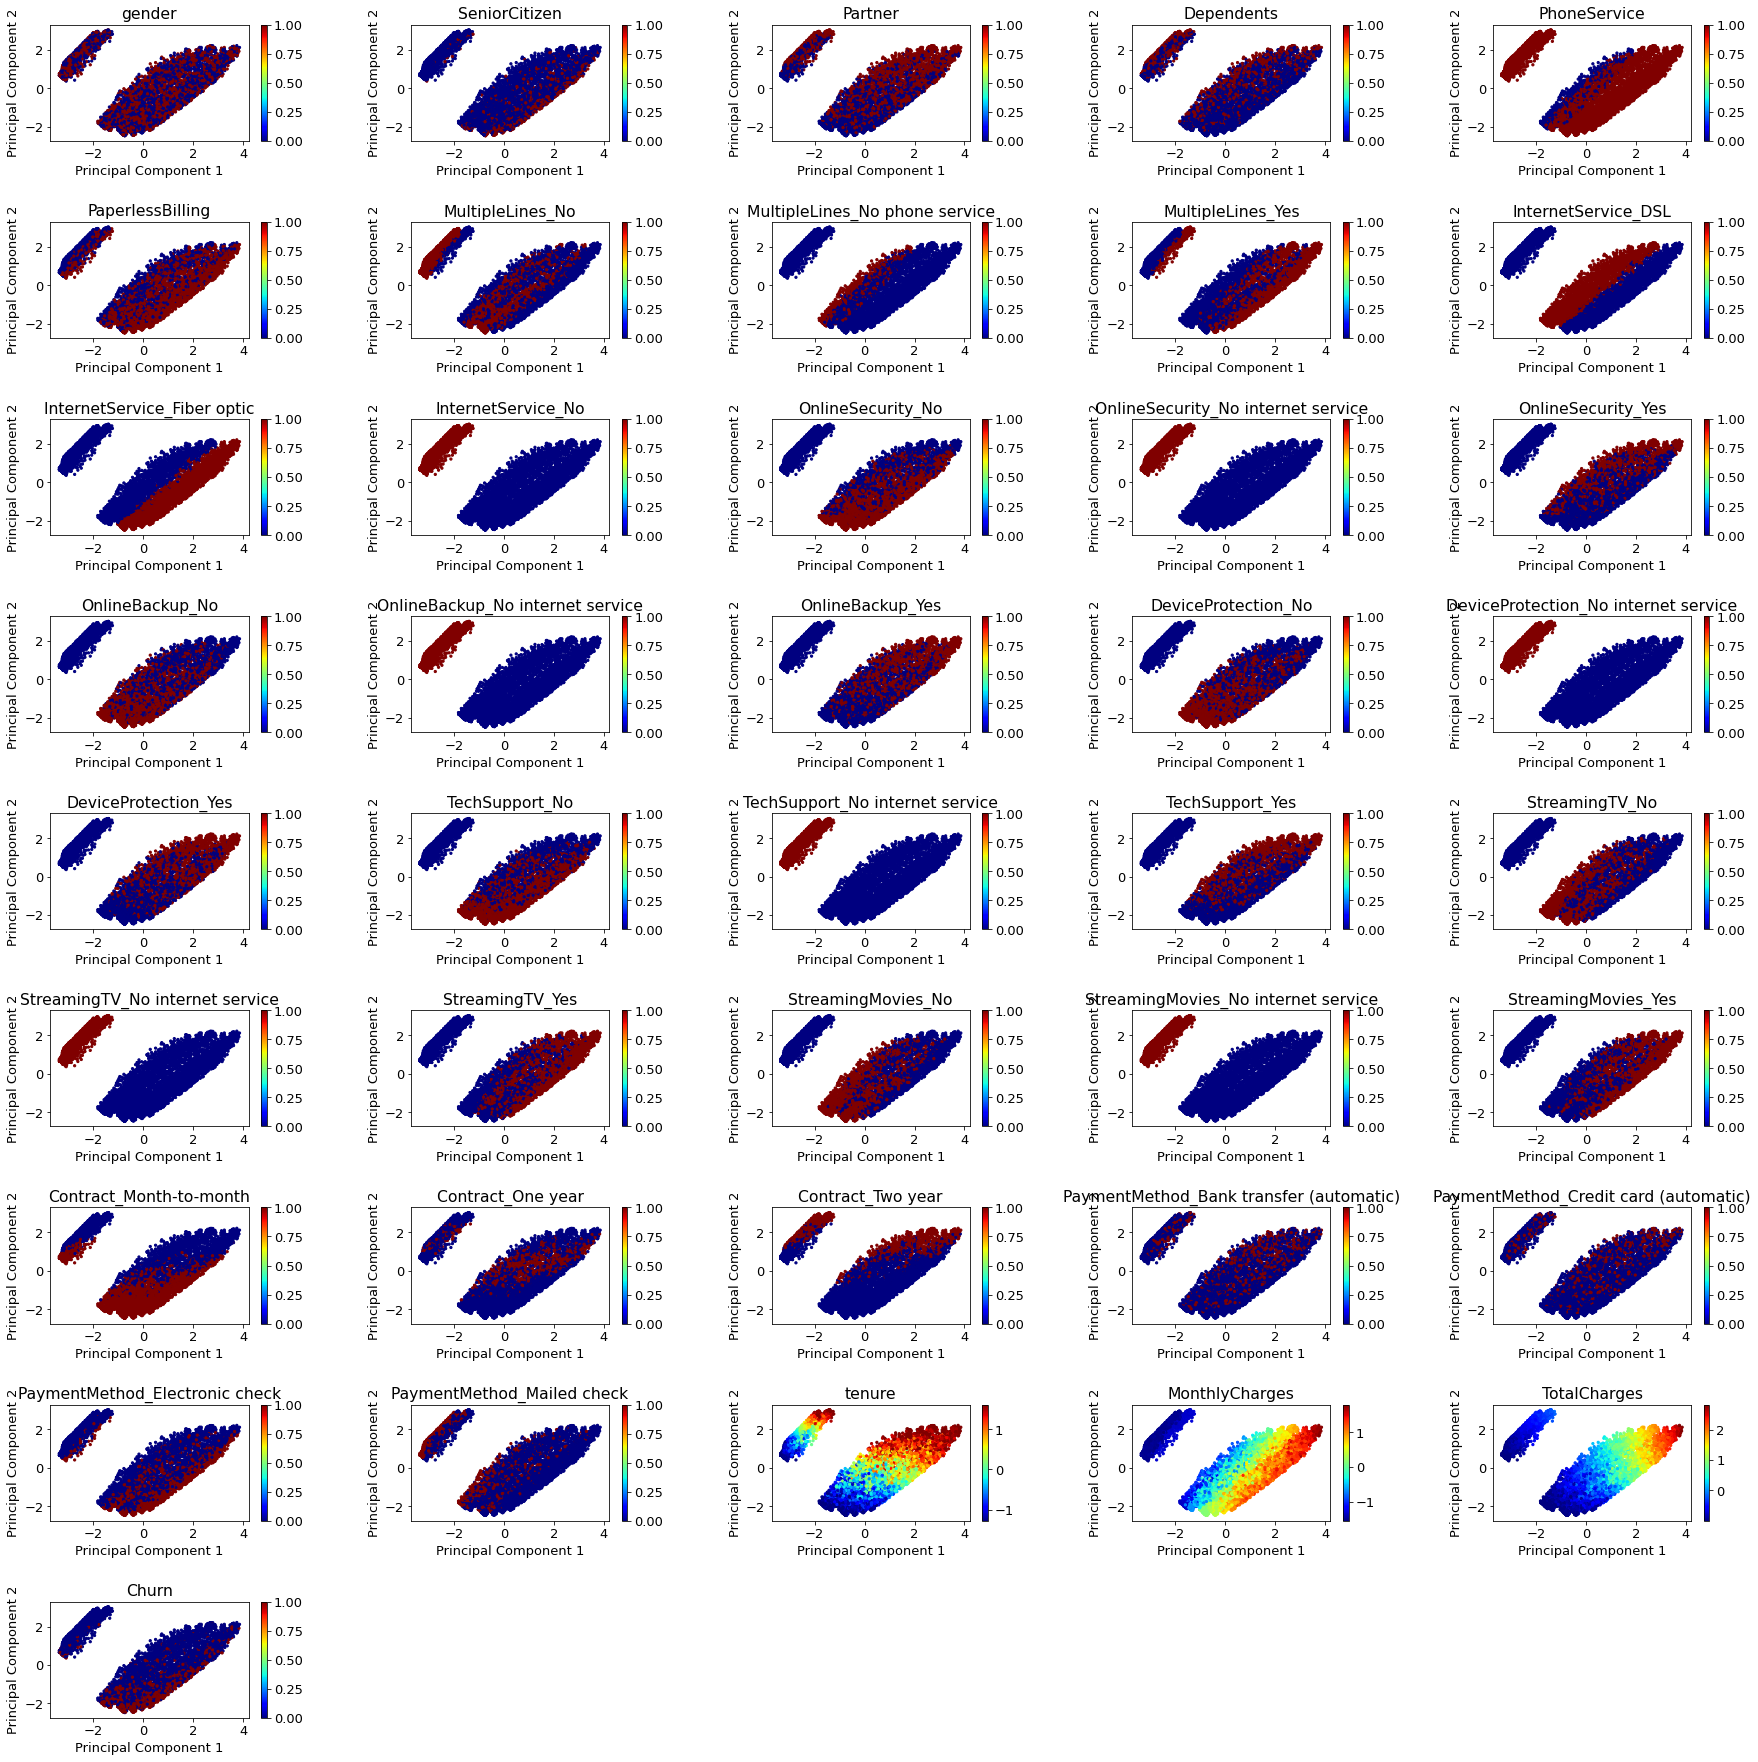

In [36]:
Tot = PCA_EVAL_ARRAY.shape[1]
Cols = 5
# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols
# Create a Position index
Position = range(1,Tot + 1)

pca = PCA(n_components=2)
transformed = pca.fit_transform(X_std)

fig = plt.figure(1, figsize=(25,25))
for k in range(Tot):

  # add every single subplot to the figure with a for loop
  ax = fig.add_subplot(Rows,Cols,Position[k])
  sc = ax.scatter(transformed[:,0], transformed[:,1], c=PCA_EVAL_ARRAY[:,k], cmap='jet', s=5)
  fig.colorbar(sc)
  ax.set_title(PCA_EVAL_NAMES[k])
  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
fig.tight_layout(pad=2)
plt.show()

## Clustering the Data (Dimensionality Reduced to 2 Principal Components)

In this section, we apply several clustering techniques which can be helpful in not only in identifying clusters that exist in the data but can also function as classification models by assigning new data points to clusters that they best map to. In this case, we only explore the former functionality (using the two principal components we obtained the prior section), as the classification modeling architectures we anticipate will have the best performmance are the decision tree model architectures we employ later.

Here we explore two clustering techniques: K-means and Gaussian Mixture Models (GMMs).  K-means is a simpler approach and essentially works by identifying the points in the dataset which, when serving as the center of a cluster, minimize the total distance between all other points and the centers of the clusters they are closest to.  Those central data points are referred to as centroids, and the default distance metric for K-means is Euclidean distance.  With GMMs, the approach is to treat each cluster as a Gaussian (i.e., normal) distribution and determine then distribution to which each data point has the highest probability of belonging to.

In this case, both clustering techniques have no issue identifying the two clusters, which are easy to see visually.

<br >

Additional reference which discusses both K-means and GMMs:
https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/

#### K-Means

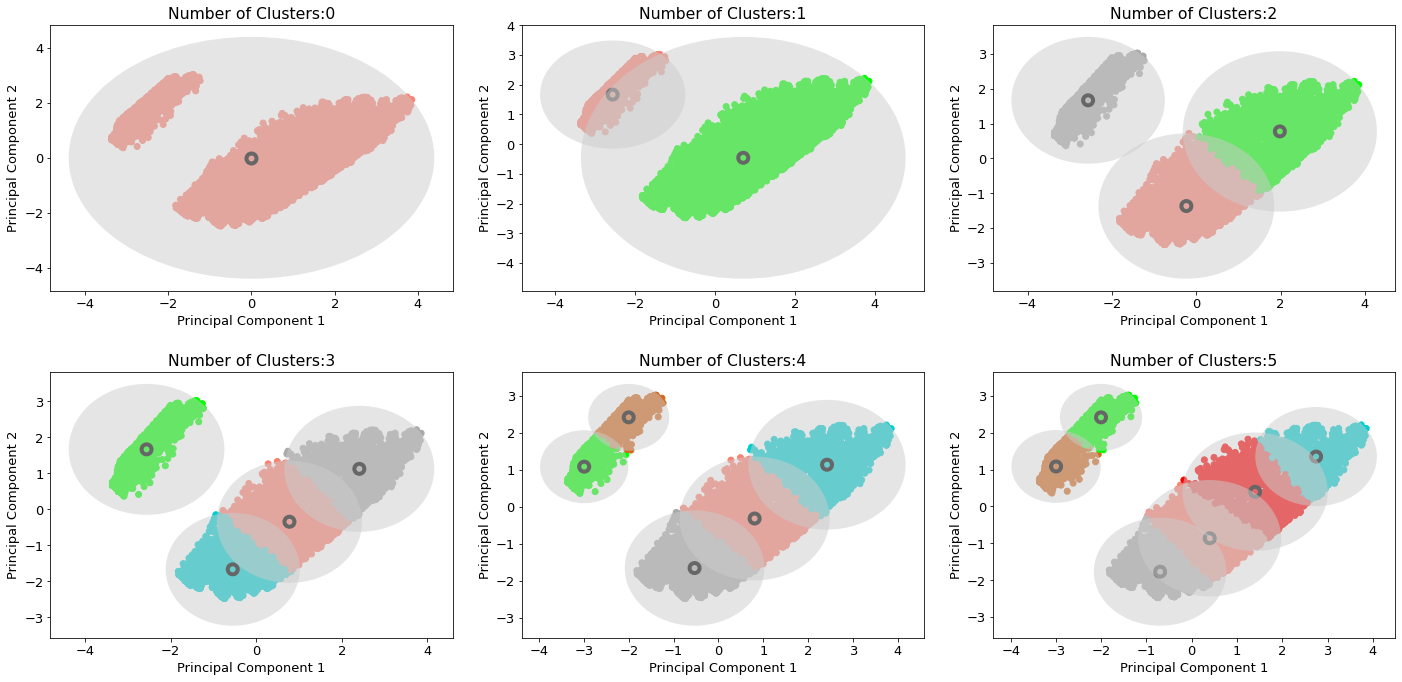

In [37]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(X_std)

Tot = 6
Cols = 3
# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols
# Create a Position index
Position = range(1,Tot + 1)

fig = plt.figure(1, figsize=(20,10))
for k in range(Tot):

    kmeans = KMeans(n_clusters=k+1, init='k-means++')
    cluster_data = kmeans.fit(transformed)
    colors = ['salmon','lime','darkgrey','darkturquoise','chocolate','red','purple','navy',
              'gold','indianred','darkorange','darkcyan','forestgreen','dodgerblue',          
              'violet','pink']

    color_list = []
    for i in range(len(cluster_data.labels_)):
        color_index = cluster_data.labels_[i]
        color_list.append(colors[color_index])
    color_vector = np.array(color_list)

    # plt.figure(figsize = (8,8))


    ax = fig.add_subplot(Rows,Cols,Position[k])
    ax.scatter(transformed[:,0], transformed[:,1],  c = color_vector)
    ax.set_title('Number of Clusters:'+str(k))
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    color_list_centroids = []
    for i in range(len(cluster_data.cluster_centers_)):
        color_index_centroids = i
        color_list_centroids.append(colors[color_index_centroids])
    color_vector_centroids = np.array(color_list_centroids)

    ax.scatter(cluster_data.cluster_centers_[:,0], cluster_data.cluster_centers_[:,1], 
                  c = color_vector_centroids, s = 100, edgecolors = 'black', linewidths = 4)


    centers = cluster_data.cluster_centers_
    labels = cluster_data.labels_
    radii = []
    for i, center in enumerate(centers):
        feature_vector = transformed[labels == i]
        test_list = []
        for j in range(len(feature_vector)):
            dist = np.linalg.norm(feature_vector[j] - center)
            test_list.append(dist)
        radii.append(max(test_list))


    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))



fig.tight_layout(pad=2)
plt.show()

#### Guassian Mixture Models (GMMs)

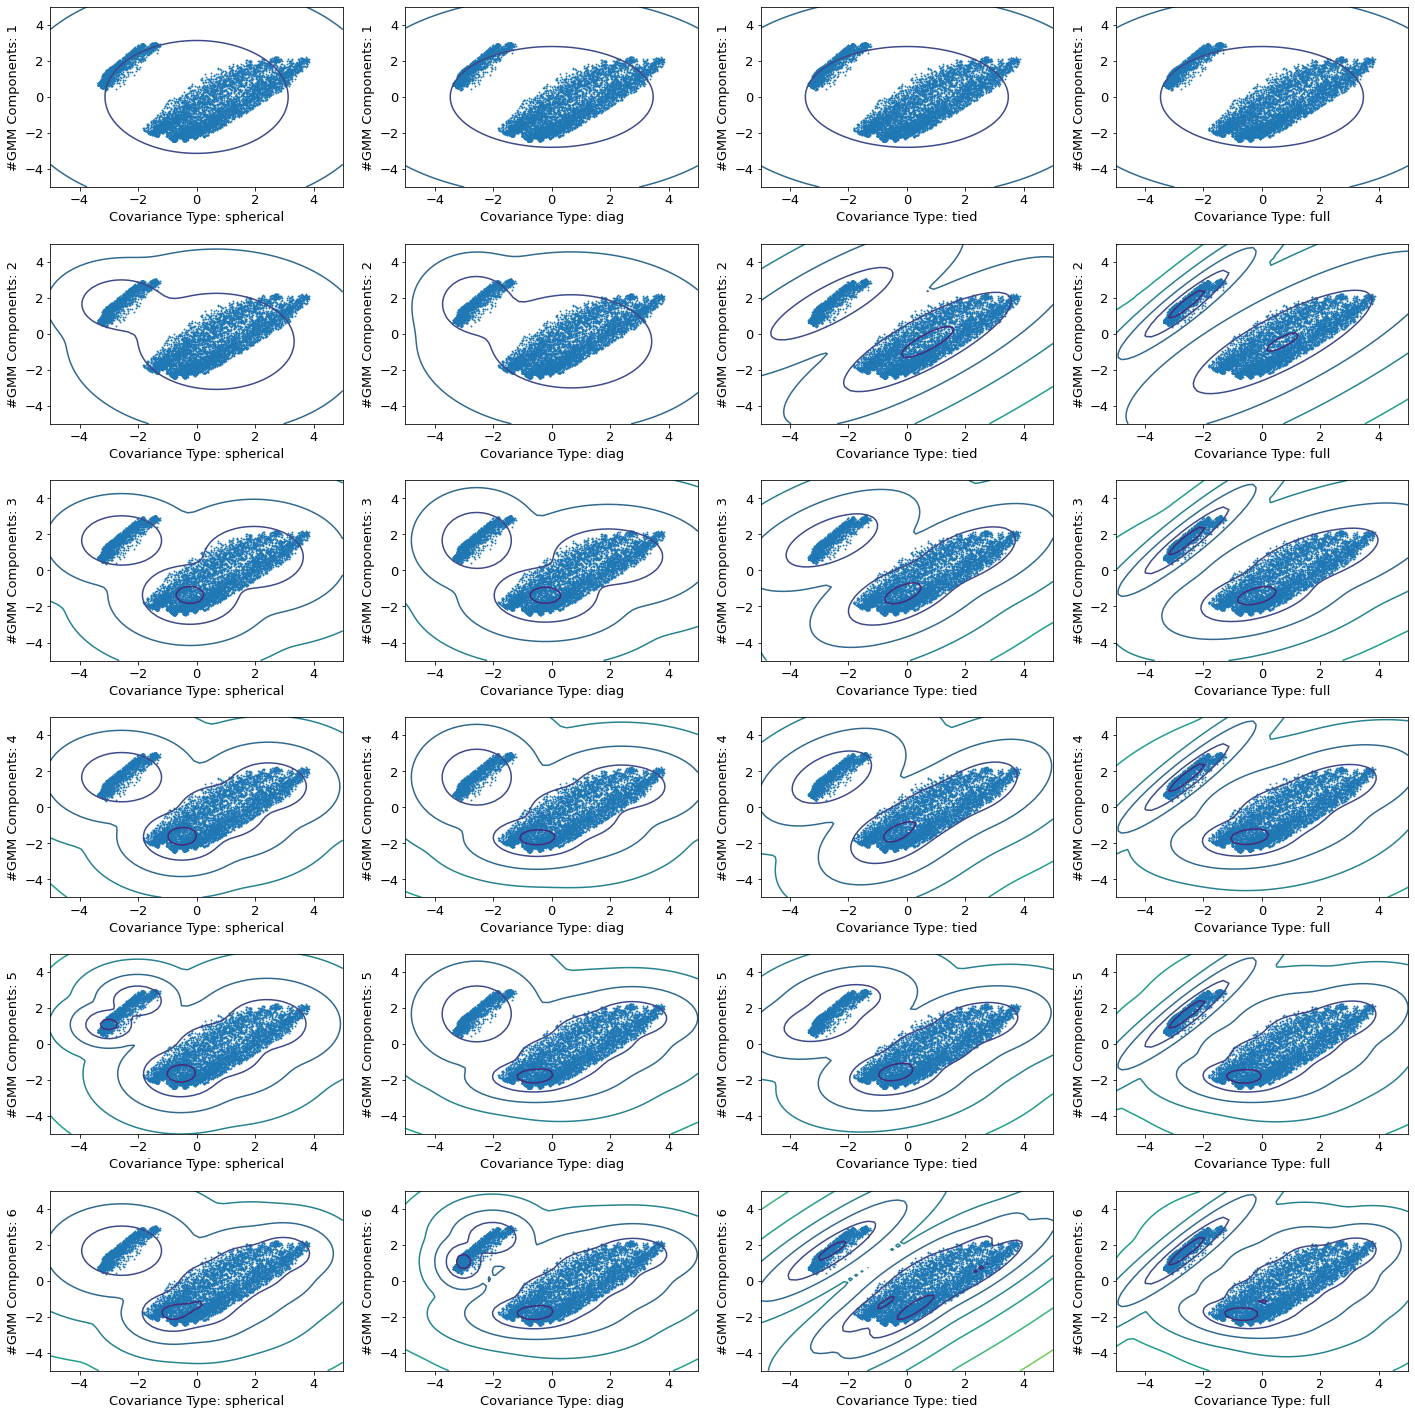

In [38]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(X_std)

# plt.colorbar(ax, shrink=0.8, extend='both')
GMM_Components = 6

fig, ax = plt.subplots(GMM_Components, 4, figsize=(20,20))

ax_counter1 = 0
for i in range(1,GMM_Components+1):

    ax_counter2 = 0
    for j in ['spherical', 'diag', 'tied', 'full']:  

        gmm = GaussianMixture(n_components=i, covariance_type=j).fit(transformed) 

        x = np.linspace(-5, 5)
        y = np.linspace(-5, 5)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -gmm.score_samples(XX)
        Z = Z.reshape(X.shape)

        ax[ax_counter1, ax_counter2].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                          levels=np.logspace(0, 3, 10))
        ax[ax_counter1, ax_counter2].scatter(transformed[:, 0], transformed[:, 1], .8)

        ax[ax_counter1, ax_counter2].set_ylabel('#GMM Components: ' + str(i))
        ax[ax_counter1, ax_counter2].set_xlabel('Covariance Type: ' + str(j))

        ax_counter2 += 1

    ax_counter1 += 1

fig.tight_layout(pad=1.5)
plt.show()

# Modeling

In this section we train two classification models to predict whether or not a customer will churn. In this case, both of these classification models are decision tree models; however, there are certainly other model architectures (e.g., logistic regression, support vector machines (SVMs), etc.) which could also be well suited to this classification task. That said, the two models that are being implemented here, Random Forest and XGBoost, generally perform quite well on classification tasks.  

This section consists of three main parts.  In the first part, we train two baseline models which use (for the most part) default hyperparameters. In the second part, we implement Bayesian Optimization in order to identify an more optimal set of hyperparameters. Finally, in the third section, we retrain the models using those hyperparameters. 

One notable aspect of the hyperparameter tuning process is that the metric which is being optimized is the net economic value which could be created if we were to use the model to drive a retention related tactic. In this case, that tactic is an outbound call placed to a customer (who is predicted to churn) in order to present that customer with a retention incentive offer.  Though there is a seperate section below which will go into a bit more detail regarding this economic framework, it is important to discuss here since it is a factor in the model development process.  The specific way we are able to translate model peformance into net economic value is expressed below in a "net_value_function".  Though this function could be made more or less complex, in its current form, there are four main components to the equation: 

1. the economic value which is created by preventing a customer from churning who would have otherwise done so (less the cost of the customer taking the incentive)
2. the cost of calling all customers who the model is predicting will churn
3. the cost of customers who would not have churned but who were contacted due to being misclassified accepting the retention incentive offer
4. a provision for a fixed cost (e.g., IT costs of maintaining the model)

In order to understand how model performance relates to this equation, it is helpful to first contemplate the tradeoffs between precision (with respect to churn classifications) and churn prediction volume in the context of this outbound call retention tactic. For example, if the cost of the outbound call and the cost of a customer accepting the retention incentive offer are both very high, then it is important to have a model with high precision (i.e., a high proportion of the churn classifications are correct), as calling customers who the model misclassifies as churners could quickly generate a net loss. Conversely, we could have a very precise model which generates only a small amount of net profit if that precision is being obtained by raising the classification threshold to a very high value and, in doing so, sacrifies churn prediction volume. So, to maximize the overall net value which is created, it is important to find the right balance between precision and churn prediction volume. Put differently, on a variable basis, one could think of precision as being a lever for profit margin and churn prediction volume being a lever for scale. In fact, on a variable basis (i.e., excluding the fixed cost component), it is possible to calculate a breakeven model precision. That is, given a set of assumptions around the effectiveness and economics of the down stream components of the tactic, it is possible to rearrange the net value equation and calculate the precision level which is requried for the overall tactic to breakeven. That equation, though it is not used in the modeling section, is also included below, as it closely related to the net value function.


## Helper Functions

In [39]:
economic_assumptions= {
'COST_OF_OUTBOUND_CALL' : 35,
'PROBABILITY_OF_TP_TAKING_TACTIC' : .10,
'VALUE_OF_IMPROVED_RETENTION_DUE_TO_TACTIC' : 1000,
'COST_OF_CUSTOMER_TAKING_TACTIC': 100,
'PROBABILITY_OF_FP_TAKING_TACTIC': .05,
'ADDITIONAL_FIXED_COSTS_OVER_TIMEFRAME' : 10000
}

def net_value_function(MODEL_PRECISION, 
                       CUSTOMERS_PREDICTED_TO_CHURN, 

                       # Benefit Components
                       PROBABILITY_OF_TP_TAKING_TACTIC, 
                       VALUE_OF_IMPROVED_RETENTION_DUE_TO_TACTIC,

                       # Cost Components 
                       COST_OF_OUTBOUND_CALL,
                       COST_OF_CUSTOMER_TAKING_TACTIC,
                       PROBABILITY_OF_FP_TAKING_TACTIC,
                       ADDITIONAL_FIXED_COSTS_OVER_TIMEFRAME):
    
    return (CUSTOMERS_PREDICTED_TO_CHURN * MODEL_PRECISION * PROBABILITY_OF_TP_TAKING_TACTIC * (VALUE_OF_IMPROVED_RETENTION_DUE_TO_TACTIC - COST_OF_CUSTOMER_TAKING_TACTIC)) \
         - (CUSTOMERS_PREDICTED_TO_CHURN * (1-MODEL_PRECISION) * PROBABILITY_OF_FP_TAKING_TACTIC * COST_OF_CUSTOMER_TAKING_TACTIC) \
         - (CUSTOMERS_PREDICTED_TO_CHURN * COST_OF_OUTBOUND_CALL) \
         - ADDITIONAL_FIXED_COSTS_OVER_TIMEFRAME

In [40]:
def breakeven_model_precision_excluding_fixed_costs(# Benefit Components
                                                    PROBABILITY_OF_TP_TAKING_TACTIC, 
                                                    VALUE_OF_IMPROVED_RETENTION_DUE_TO_TACTIC,

                                                    # Cost Components 
                                                    COST_OF_OUTBOUND_CALL,
                                                    COST_OF_CUSTOMER_TAKING_TACTIC,
                                                    PROBABILITY_OF_FP_TAKING_TACTIC,
                                                    ):
            
    return   (COST_OF_OUTBOUND_CALL/((PROBABILITY_OF_TP_TAKING_TACTIC * (VALUE_OF_IMPROVED_RETENTION_DUE_TO_TACTIC - COST_OF_CUSTOMER_TAKING_TACTIC)) + (PROBABILITY_OF_FP_TAKING_TACTIC * COST_OF_CUSTOMER_TAKING_TACTIC))) + \
             ((PROBABILITY_OF_FP_TAKING_TACTIC * COST_OF_CUSTOMER_TAKING_TACTIC)/((PROBABILITY_OF_TP_TAKING_TACTIC * (VALUE_OF_IMPROVED_RETENTION_DUE_TO_TACTIC - COST_OF_CUSTOMER_TAKING_TACTIC)) + (PROBABILITY_OF_FP_TAKING_TACTIC * COST_OF_CUSTOMER_TAKING_TACTIC)))


## Preparation of Dataset for Modeling

In this section we split the data into training, development, and test data. In this case, the development dataset is used in the hyperparameter tuning process, as it is important to avoid any degree of overfitting (in terms of the performance obtained when using certain hyperparameters) on the test dataset.  We also create seperate Pandas series which contain the customer IDs, as they are not useful in the model but will be needed after the model generates its ouput (so we can know who the probabilities/classifications correspond to).

In [41]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [43]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size = .2)

In [44]:
X_train_IDs = X_train['customerID']
X_train.drop('customerID', axis=1, inplace=True)
X_dev_IDs = X_dev['customerID']
X_dev.drop('customerID', axis=1, inplace=True)
X_test_IDs = X_test['customerID']
X_test.drop('customerID', axis=1, inplace=True)

In [45]:
majority_class = y_train.value_counts().sort_values(ascending = False).reset_index().iloc[0]['index']

## Training and Evaluating Baseline Binary Classifiers

### Model Training and Evaluation

#### XGBoost

In this section, we train a baseline XGBoost model, which essentially a gradient boosting tree model with some additional optimization techniques built in. XGBoost stands for extreme gradient boosting, and, at the highest level, it functions by sequentially training decision trees and then, after constructing each tree, calculating the loss using a loss function and then utilizing gradient descent to tweak the weights such that the performance of the next tree which is created improves.

In terms of model evaluation, there are several things which we assess in this section. First it is helpful in understanding how model performance is changing (for both the training and the validation (i.e., development) datasets) with respect to the number of trees that are trained. We look at a number of important metrics for a classification model, however, the one of primary interest is the net value which can be created with the model when evaluated across a range of classification thresholds.

It's also important to understand the relative importance of the individual features which are being used in the model. In this case, we can see that whether or not a customer is in a month-to-month contract is the most important feature by a fairly wide margin.

<br >

Additional reference on XGBoost: <br >
https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d


In [171]:
def xgb_custom_eval(probs, label, economic_assumptions = economic_assumptions, single_threshold = .5, starting_threshold=.3, ending_threshold=.9):
    labels_ = label.get_label()
    y_bin = (probs > single_threshold).astype(int)
    f1_score_macro = f1_score(labels_, y_bin, average="macro")
    f1_score_binary = f1_score(labels_, y_bin, average="binary")

    model_outputs = []
    for i in range(int(starting_threshold*100), int(ending_threshold*100)+1, 1):
      i = i/100
      y_bin = (probs > i).astype(int)
      TN, FP, FN, TP = confusion_matrix(labels_, y_bin, labels=[0, 1]).ravel()
      if FP == 0 & TP == 0:
          precision = 0
      else:
          precision = TP/(FP+TP)
      prediction_volume = (TP + FP)/((len(labels_)/len(df)))
      model_outputs.append(net_value_function(precision, prediction_volume, **economic_assumptions))
    return [("f1", f1_score_macro), ('f1_minority', f1_score_binary), ('net_value', max(model_outputs))]

In [172]:
scale_pos_weight = (len(y_dev)- sum(y_dev))/sum(y_dev)

In [173]:
xgb_model = XGBClassifier(objective = 'binary:logistic', 
                          eval_metric = ['logloss', 'auc', 'error'],
                          tree_method = "gpu_hist", 
                          # predictor='cpu_predictor',
                          scale_pos_weight = scale_pos_weight)

In [174]:
eval_set = [(X_train, y_train), (X_dev, y_dev)]
xgb_model.fit(X_train, y_train, eval_metric=xgb_custom_eval, eval_set=eval_set, verbose=False)

XGBClassifier(eval_metric=['logloss', 'auc', 'error'],
              scale_pos_weight=2.8203389830508474, tree_method='gpu_hist')

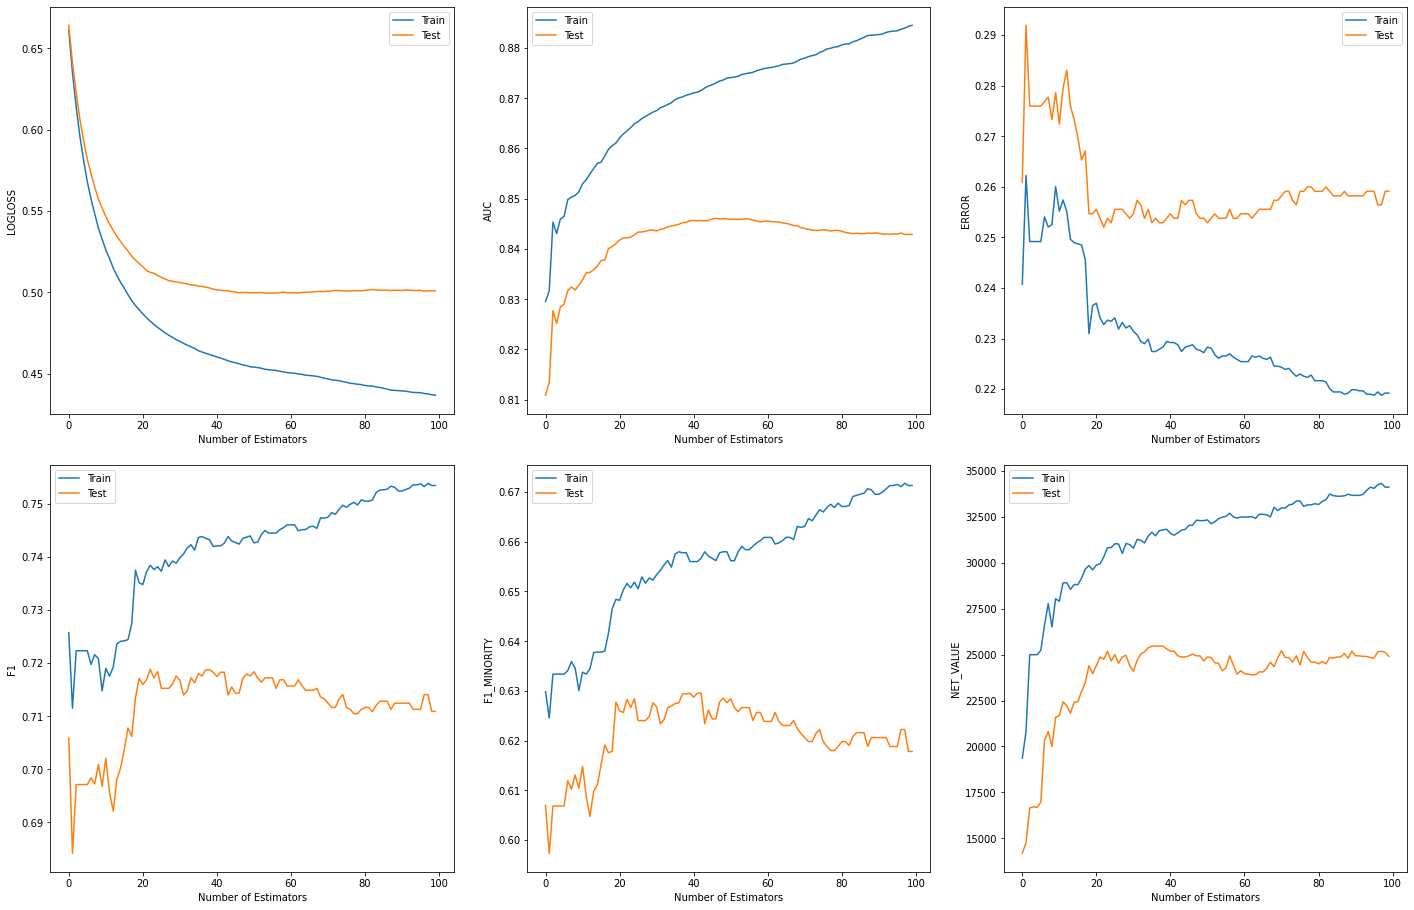

In [175]:
Tot = len(list(xgb_model.evals_result_['validation_0'].keys()))
Cols = 3
# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols
# Create a Position index
Position = range(1,Tot + 1)

history = xgb_model.evals_result_
eval_metrics = list(xgb_model.evals_result_['validation_0'].keys())
x_axis = range(len(history['validation_0'][eval_metrics[0]]))

fig = plt.figure(1, figsize=(20,13))
for k in range(Tot):

  # add every single subplot to the figure with a for loop
  ax = fig.add_subplot(Rows,Cols,Position[k])
  ax.plot(x_axis, history['validation_0'][eval_metrics[k]], label='Train')
  ax.plot(x_axis, history['validation_1'][eval_metrics[k]], label='Test')
  ax.set_xlabel('Number of Estimators')
  ax.set_ylabel(str(eval_metrics[k]).upper())
  l = ax.legend()


fig.tight_layout(pad=2)
plt.show()

In [176]:
y_pred_class_xgb = xgb_model.predict(X_test)

In [177]:
y_pred_probs_xgb = xgb_model.predict_proba(X_test)

In [178]:
print(classification_report(y_test, y_pred_class_xgb))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1033
           1       0.52      0.79      0.63       376

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



In [179]:
feature_importances_xgb = pd.DataFrame({'Model_Importance': xgb_model.feature_importances_, 'Feature': [x.upper() for x in X_train.columns]}).sort_values('Model_Importance')
feature_importances_xgb = feature_importances_xgb[feature_importances_xgb['Model_Importance'] > .005]

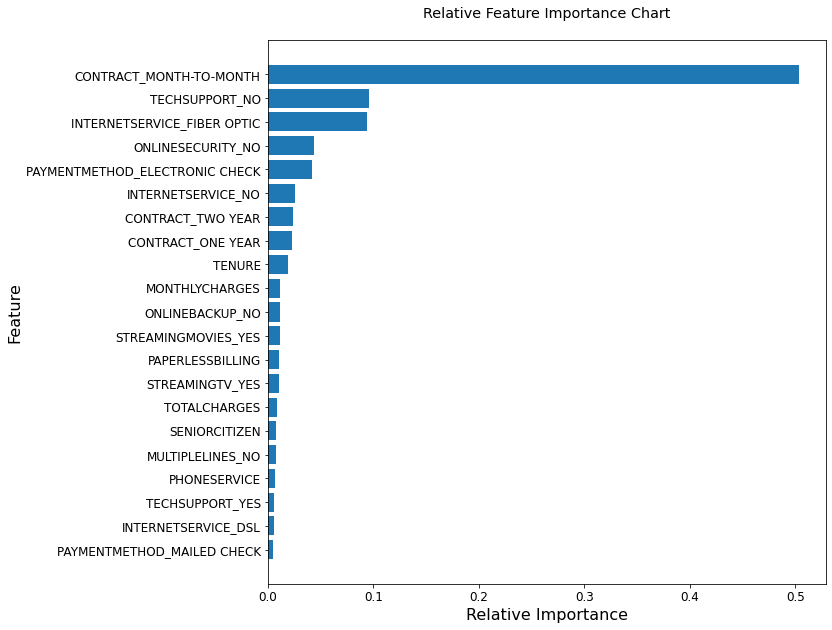

In [180]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 10))
plt.barh(feature_importances_xgb['Feature'], feature_importances_xgb['Model_Importance'])
plt.xlabel('Relative Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Relative Feature Importance Chart\n')
plt.show()

#### Random Forest

In this section, we train a Random Forest decision tree model. This model functions differently from XGBoost in that there is no iterative tree creation process which leverages gradient descent with a loss function. Instead a number of smaller decision trees are created, where each tree is only looking at a subset of the features and a subset of the dataset, and then classification is made by picking the class which is predicted the most by the individual trees.

In terms of model evaluation, we can see that this model performs somewhat similarly to the XGBoost model in terms of precision, recall, and F1 (though recall is a bit lower for churn predictions with this model).  We can also see that the relative importance of the features used in the model is a bit more evenly distributed and that the most important feature, in this case, is actually `TotalCharges`, followed closely by `Tenure` and `MonthlyCharges`.

<br >

Additional reference for Random Forest: <br >
https://towardsdatascience.com/understanding-random-forest-58381e0602d2

In [181]:
X_train_no_na_index = X_train.isnull().any(axis=1)
X_dev_no_na_index = X_dev.isnull().any(axis=1)
X_test_no_na_index = X_test.isnull().any(axis=1)

In [182]:
X_train_no_na = X_train[~X_train_no_na_index]
y_train_no_na = y_train[~X_train_no_na_index]

X_dev_no_na = X_dev[~X_dev_no_na_index]
y_dev_no_na = y_dev[~X_dev_no_na_index]

X_test_no_na = X_test[~X_test_no_na_index]
y_test_no_na = y_test[~X_test_no_na_index]

In [183]:
rf_model = RandomForestClassifier(class_weight = 'balanced')

In [184]:
rf_model.fit(X_train_no_na, y_train_no_na)

RandomForestClassifier(class_weight='balanced')

In [185]:
y_pred_class_rf = rf_model.predict(X_test_no_na)

In [186]:
y_pred_probs_rf = rf_model.predict_proba(X_test_no_na)

In [187]:
print(classification_report(y_test_no_na, y_pred_class_rf))

              precision    recall  f1-score   support

           0       0.81      0.90      0.86      1032
           1       0.62      0.43      0.51       376

    accuracy                           0.78      1408
   macro avg       0.72      0.67      0.68      1408
weighted avg       0.76      0.78      0.76      1408



In [188]:
feature_importances_rf = pd.DataFrame({'Model_Importance': rf_model.feature_importances_, 'Feature': [x.upper() for x in X_train_no_na.columns]}).sort_values('Model_Importance')
feature_importances_rf = feature_importances_rf[feature_importances_rf['Model_Importance'] > .005]

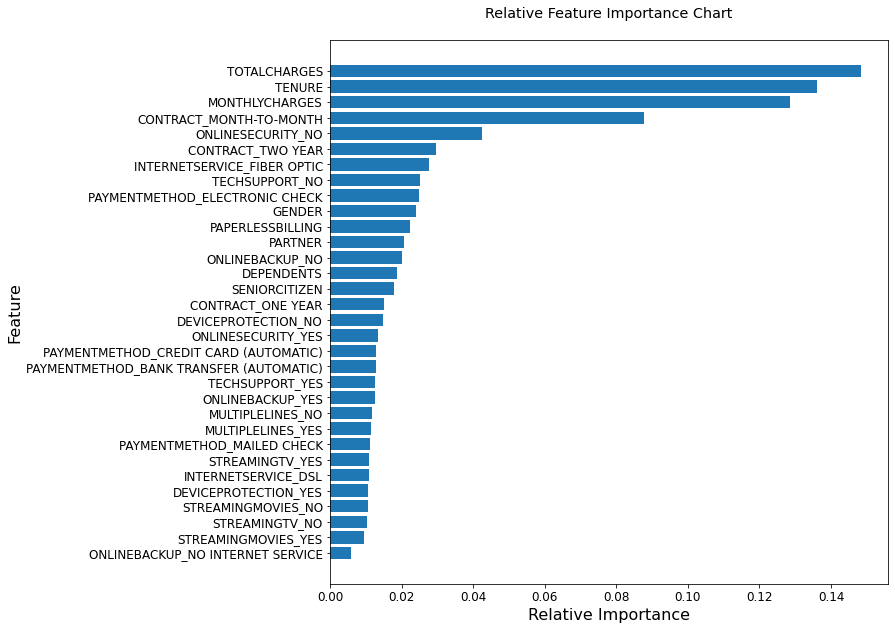

In [189]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 10))
plt.barh(feature_importances_rf['Feature'], feature_importances_rf['Model_Importance'])
plt.xlabel('Relative Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Relative Feature Importance Chart\n')
plt.show()

### Combined Model Evaluation

Now that we have trained and individually evaluated both of the baseline models, we can create several plots which allow us to assess the performance of both models simultaneously and do so over a range of classification thresholds. The two plots shown below are a ROC curve and Precision-Recall curve. The ROC curve is a more typical plot to gauge model performance; however, for imbalanced datasets (which we do have to an extent), a precision recall curve (which is looking exclusively at the performance of the model on the minority class (i.e., churn predictions)) can be more useful.

In both plots, we can see that the XGBoost model slightly outperforms the Random Forest model. Numerically, we can see this by comparing the area under the curves for both models.

In [190]:
ns_probs = [majority_class for x in range(len(y_test))]

xgb_model_probs = y_pred_probs_xgb[:,1]
rf_model_probs = y_pred_probs_rf[:,1]

#### ROC Curves

No Skill: ROC AUC=0.500
XGBoost ROC AUC=0.833
Random Forest ROC AUC=0.810


[]

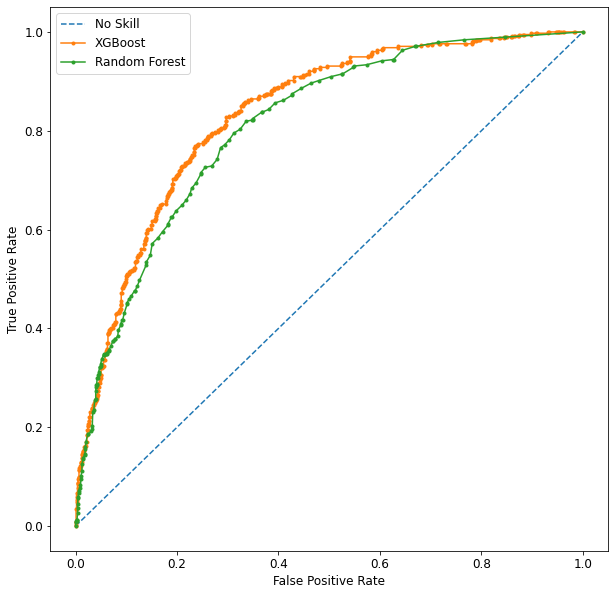

In [191]:
plt.figure(figsize=(10,10))

ns_auc = roc_auc_score(y_test, ns_probs)
xgb_model_auc = roc_auc_score(y_test, xgb_model_probs)
rf_model_auc = roc_auc_score(y_test_no_na, rf_model_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost ROC AUC=%.3f' % (xgb_model_auc))
print('Random Forest ROC AUC=%.3f' % (rf_model_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_model_fpr, xgb_model_tpr, _ = roc_curve(y_test, xgb_model_probs)
rf_model_fpr, rf_model_tpr, _ = roc_curve(y_test_no_na, rf_model_probs)

plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'No Skill')
plt.plot(xgb_model_fpr,  xgb_model_tpr, marker = '.', label = 'XGBoost')
plt.plot(rf_model_fpr,  rf_model_tpr, marker = '.', label = 'Random Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.plot()

#### Precision-Recall Curves

No Skill: PR AUC=0.267
XGBoost PR AUC=0.632
Random Forest PR AUC=0.594


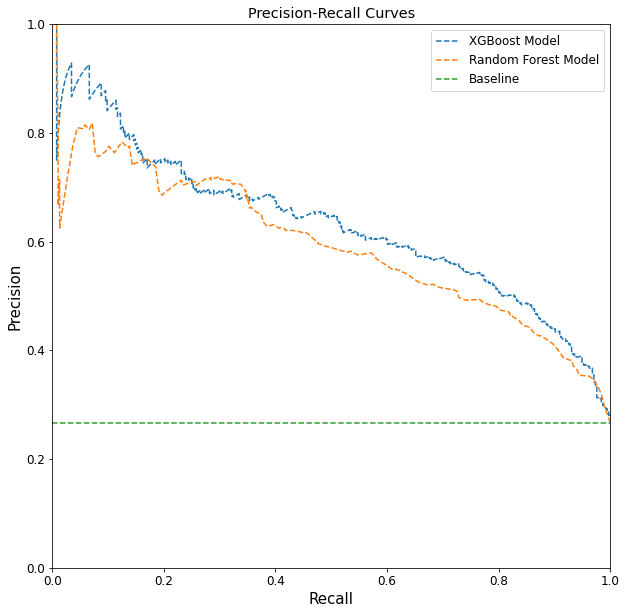

In [192]:
plt.figure(figsize=(10,10))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_model_probs, pos_label=1)
precision_rf, recall_rf, _ = precision_recall_curve(y_test_no_na, rf_model_probs, pos_label=1)

no_skill = len(y_test[y_test == 1])/len(y_test)

print('No Skill: PR AUC=%.3f' % (auc([0,1], [no_skill, no_skill])))
print('XGBoost PR AUC=%.3f' % (auc(recall_xgb, precision_xgb)))
print('Random Forest PR AUC=%.3f' % (auc(recall_rf, precision_rf)))

plt.plot(recall_xgb, precision_xgb, linestyle='--', label='XGBoost Model')
plt.plot(recall_rf, precision_rf, linestyle='--', label='Random Forest Model')
plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='Baseline')

plt.xlabel('Recall', size = 15)
plt.ylabel('Precision', size = 15)

plt.title('Precision-Recall Curves')

plt.xlim(0,1)
plt.ylim(0,1)

plt.legend()

plt.show()

## Bayesian Optimization for Hyperparameter Tuning

In this section, we utilize Bayesian Optimization to identify a more optimal set of hyperparameter than that which the model will use by default. Unlike more common techniques which are used to identify a more optimal set of hyperparameters, such as GridSearch or RandomSearch, Bayesian Optimization works to identify the best hyperparameters by treating them as variables in a function which is progressively better understood through trial and error. Once the function begins to become better understood, the points which are evaluated will begin to concentrate around the global minimum of the function (which would correspond to set of hyperparameters which produce the most optimal overall model output). In this case, we again use the net value function as the metric which is being evaluated and driving the optimization process.

<br >

Additional References for Bayesian Optimization: <br >
https://towardsdatascience.com/the-beauty-of-bayesian-optimization-explained-in-simple-terms-81f3ee13b10f
https://machinelearningmastery.com/what-is-bayesian-optimization/


In [193]:
dtrain = xgb.DMatrix(X_train, label = y_train)

### XGBoost

In [268]:
def xgb_custom_eval_for_bo(probs, label, economic_assumptions = economic_assumptions, starting_threshold=.3, ending_threshold=.9):
    labels_ = label.get_label()
    model_outputs = []
    for i in range(int(starting_threshold*100), int(ending_threshold*100)+1, 1):
      i = i/100
      y_bin = (probs > i).astype(int)
      TN, FP, FN, TP = confusion_matrix(labels_, y_bin, labels=[0, 1]).ravel()
      if FP == 0 & TP == 0:
          precision = 0
      else:
          precision = TP/(FP+TP)
      prediction_volume = (TP + FP)/((len(labels_)/len(df)))
      model_outputs.append(net_value_function(precision, prediction_volume, **economic_assumptions))
    return 'net_value', max(model_outputs)

In [269]:
# https://www.kaggle.com/tilii7/bayesian-optimization-of-xgboost-parameters

def XGB_CV(
    max_depth
    ,gamma
    ,eta
    ,max_delta_step
    ,subsample
    ,colsample_bytree
    ,min_child_weight
    ,scale_pos_weight_switch
):

  global iteration

  if scale_pos_weight_switch >= .5:
    scale_pos_weight_bo = np.sqrt(scale_pos_weight)
  else:
    scale_pos_weight_bo = scale_pos_weight

  params = {
      'booster': 'gbtree'
      ,'objective': 'binary:logistic'
      # ,'eval_metric': 'auc'
      ,'tree_method': 'gpu_hist'
      ,'scale_pos_weight': scale_pos_weight_bo
      ,'max_depth': int(max_depth)
      ,'gamma': gamma
      ,'eta': eta
      ,'max_delta_step': int(max_delta_step)
      ,'subsample': max(min(subsample, 1), 0)
      ,'colsample_bytree' : max(min(colsample_bytree, 1), 0)
      ,'min_child_weight': min_child_weight
      ,'disable_default_eval_metric': 1
  }

  folds = 5

  xgbc = xgb.cv(
                  params,
                  dtrain,
                  num_boost_round = 20000,
                  stratified = True,
                  nfold = folds,
  #                    verbose_eval = 10,
                  early_stopping_rounds = 100,
                  # metrics = 'auc',
                  show_stdv = True,
                  feval = xgb_custom_eval_for_bo,
                  maximize = True
              )

  val_score = xgbc['test-net_value-mean'].iloc[-1]
  train_score = xgbc['train-net_value-mean'].iloc[-1]
  print(' Stopped after %d iterations with train-net_value = %f val-net_value = %f ( diff = %f )' % ( len(xgbc), 
                                                                                                                        train_score, 
                                                                                                                        val_score, 
                                                                                                                        (train_score - val_score)
                                                                                                      ))

  BO_Dict[iteration] = {'validation_net_value': val_score}
  BO_Dict[iteration].update(params)
  iteration += 1

  return val_score/1000000

In [270]:
iteration = 0
BO_Dict = {}

In [271]:
pbounds = {
    'max_depth': (2, 12)
    ,'gamma': (0.001, 10.0)
    ,'eta': (.0001, .4)
    ,'max_delta_step': (0, 10)
    ,'subsample': (0.4, 1.0)
    ,'colsample_bytree' :(0.4, 1.0)
    ,'min_child_weight': (0, 20)
    ,'scale_pos_weight_switch': (0.0, 1.0)
}

In [272]:
XGB_BO = BayesianOptimization(f = XGB_CV
                              ,pbounds = pbounds)

In [273]:
print('-'*130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    XGB_BO.maximize(init_points=5, n_iter=25, acq='ei')

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | colsam... |    eta    |   gamma   | max_de... | max_depth | min_ch... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
 Stopped after 20 iterations with train-net_value = 55394.240616 val-net_value = 27204.792095 ( diff = 28189.448521 )
|  1        |  0.0272   |  0.8309   |  0.2215   |  4.434    |  5.404    |  8.049    |  4.505    |  0.5163   |  0.8705   |
 Stopped after 352 iterations with train-net_value = 30649.112509 val-net_value = 30619.819737 ( diff = 29.292771 )
|  2        |  0.03062  |  0.8878   |  0.01824  |  5.789    |  5.838    |  2.902    |  9.586    |  0.8042   |  0.5109   |
 Stopped after 10 iterations with train-net_value = 36724.019729 val-net_value = 28478.343964 ( diff = 8245.675766 )
|  3        |  0.02848  |  0.4

In [274]:
XGB_BO_DF = pd.DataFrame(BO_Dict).T
XGB_BO_DF.rename(columns = {'eta': 'learning_rate'}, inplace=True)
XGB_BO_DF.sort_values('validation_net_value', ascending=False, inplace=True)

In [275]:
XGB_params = dict(XGB_BO_DF[['booster','objective','scale_pos_weight','max_depth','gamma','learning_rate','max_delta_step','subsample','colsample_bytree','min_child_weight']].iloc[0])

In [276]:
XGB_params

{'booster': 'gbtree',
 'colsample_bytree': 0.7237279212858121,
 'gamma': 7.138319894561948,
 'learning_rate': 0.08596875321664978,
 'max_delta_step': 2,
 'max_depth': 2,
 'min_child_weight': 13.504985256480836,
 'objective': 'binary:logistic',
 'scale_pos_weight': 2.8203389830508474,
 'subsample': 0.9804490920630178}

### Random Forest

In [550]:
def rf_custom_eval_for_bo(binary_clf, X, y, economic_assumptions = economic_assumptions, starting_threshold=.3, ending_threshold=.9):
    probs = binary_clf.predict_proba(X)[:,1]
    model_outputs = []
    for i in range(int(starting_threshold*100), int(ending_threshold*100)+1, 1):
      i = i/100
      y_bin = (probs > i).astype(int)
      TN, FP, FN, TP = confusion_matrix(y, y_bin, labels=[0, 1]).ravel()
      if FP == 0 & TP == 0:
          precision = 0
      else:
          precision = TP/(FP+TP)
      prediction_volume = (TP + FP)/((len(y)/len(df)))
      model_outputs.append(net_value_function(precision, prediction_volume, **economic_assumptions))
    return {'net_value' : max(model_outputs)}

In [551]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://www.kdnuggets.com/2019/07/xgboost-random-forest-bayesian-optimisation.html
# https://pierpaolo28.github.io/blog/blog25/
# https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object
# https://www.programcreek.com/python/example/99823/xgboost.cv

def RF_CV(
      bootstrap_switch
      ,max_features_switch
      ,class_weight_switch
      ,n_estimators
      ,max_depth
      ,min_samples_leaf
      ,min_samples_split
      ):

  global iteration

  if bootstrap_switch >= .5:
    bootstrap_bo = True
  else:
    bootstrap_bo = False

    
  if max_features_switch >= .5:
    max_features_bo = 'auto'
  else:
    max_features_bo = 'sqrt'
    
    
  if class_weight_switch >= .5:
    class_weight_bo = 'balanced'
  else:
    class_weight_bo = 'balanced_subsample'    
    
    
  params = {
      # 'criterion': 'gini'
      'bootstrap': bootstrap_bo,
      'max_features': max_features_bo,
      'class_weight': class_weight_bo,
      'n_estimators': int(n_estimators),
      'max_depth': int(max_depth),
      'min_samples_leaf': int(min_samples_leaf),
      'min_samples_split': int(min_samples_split),
  }

  score = cross_validate(RandomForestClassifier(**params), X = X_train_no_na, y = y_train_no_na, cv=5, scoring=rf_custom_eval_for_bo)['test_net_value'].mean()

  BO_Dict[iteration] = {'test_net_value': score}
  BO_Dict[iteration].update(params)
  iteration += 1

  return score/1000000


In [552]:
iteration = 0
BO_Dict = {}

In [553]:
pbounds = {
    'bootstrap_switch': (0.0, 1.0),
    'max_features_switch': (0.0, 1.0),
    'class_weight_switch': (0.0, 1.0),
    'n_estimators': (100,500),
    'max_depth': (1,20),
    'min_samples_leaf': (1,5),
    'min_samples_split': (2, 11),
  }

In [554]:
RF_BO = BayesianOptimization(f = RF_CV
                              ,pbounds = pbounds)

In [555]:
print('-'*130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
#     RF_BO.maximize(init_points=1, n_iter=1, acq='ei', xi=0.0)
    RF_BO.maximize(init_points=5, n_iter=25, acq='ei')


----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | bootst... | class_... | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.02713  |  0.718    |  0.6996   |  8.806    |  0.0418   |  2.588    |  5.894    |  415.5    |
|  2        |  0.02672  |  0.8656   |  0.2735   |  14.38    |  0.5699   |  3.53     |  2.998    |  163.0    |
|  3        |  0.02403  |  0.2633   |  0.273    |  1.7      |  0.8364   |  2.63     |  10.49    |  322.5    |
|  4        |  0.02631  |  0.8867   |  0.583    |  11.59    |  0.03387  |  3.232    |  2.129    |  235.6    |
|  5        |  0.02501  |  0.6273   |  0.7925   |  3.631    |  0.2891   |  1.512    |  2.102    |  436.3    |
|  6        |  0.02671  |  0.91     |  0.9449   |  9.139    |  0.8565   |  2.428    |  5.343    |  

In [556]:
RF_BO_DF = pd.DataFrame(BO_Dict).T

In [557]:
RF_BO_DF.sort_values('test_net_value', ascending=False, inplace=True)

In [558]:
RF_params = dict(RF_BO_DF[['bootstrap','max_features','class_weight','n_estimators','max_depth','min_samples_leaf','min_samples_split']].iloc[0])

## Retraining and Evaluating Binary Classifiers with Tuned Hyperparameters

Now that we have identified a more optimal set of hyperparameter for both the XGBoost model and the Random Forest model, we can retrain those models using those hyperparameters and compare their peformance to the baseline models. Additionally, for the XGBoost model, we determine the optimal number of trees for the selected hyperparameters by implementing an "early stopping" functionality. This feature assesses model performance against the validation dataset after the creation of each tree, and after performance has not increased for a number of trees (50 in this case), model training halts. In any event, based on the comparison between the baseline models and the models with the tuned hyperparameters, we observed only modest improvements in model performance when using conventional metrics such as the area under the ROC or Precision Recall curves. However, in the next section, when we assess the improvement in model's ability to create net value, the optimization results in improvements which are more material.

### Model Training and Evaluation

#### XGBoost

In [52]:
def xgb_economic_gain_eval(probs, label, economic_assumptions = economic_assumptions, single_threshold = .5, starting_threshold=.3, ending_threshold=.9):
    labels_ = label.get_label()
    y_bin = (probs > single_threshold).astype(int)
    model_outputs = []
    for i in range(int(starting_threshold*100), int(ending_threshold*100)+1, 1):
      i = i/100
      y_bin = (probs > i).astype(int)
      TN, FP, FN, TP = confusion_matrix(labels_, y_bin, labels=[0, 1]).ravel()
      if FP == 0 & TP == 0:
          precision = 0
      else:
          precision = TP/(FP+TP)
      prediction_volume = (TP + FP)/((len(labels_)/len(df)))
      model_outputs.append(net_value_function(precision, prediction_volume, **economic_assumptions))
    return ('net_value', max(model_outputs))

In [278]:
XGB_params

{'booster': 'gbtree',
 'colsample_bytree': 0.7237279212858121,
 'gamma': 7.138319894561948,
 'learning_rate': 0.08596875321664978,
 'max_delta_step': 2,
 'max_depth': 2,
 'min_child_weight': 13.504985256480836,
 'objective': 'binary:logistic',
 'scale_pos_weight': 2.8203389830508474,
 'subsample': 0.9804490920630178}

In [279]:
xgb_model_tuned = XGBClassifier(**XGB_params, 
                                n_estimators=400, 
                                early_stopping_rounds = 50, 
                                tree_method = "gpu_hist",
                                disable_default_eval_metric = 1,
)

In [280]:
eval_set = [(X_train, y_train), (X_dev, y_dev)]
xgb_model_tuned.fit(X_train, y_train, eval_metric=xgb_economic_gain_eval, eval_set=eval_set, verbose=False, callbacks=[xgb.callback.early_stop(20, maximize=True)])

Multiple eval metrics have been passed: 'validation_1-net_value' will be used for early stopping.

Will train until validation_1-net_value hasn't improved in 20 rounds.
Stopping. Best iteration:
[60]	validation_0-net_value:29879.6	validation_1-net_value:26964.8



XGBClassifier(colsample_bytree=0.7237279212858121,
              disable_default_eval_metric=1, early_stopping_rounds=50,
              gamma=7.138319894561948, learning_rate=0.08596875321664978,
              max_delta_step=2, max_depth=2,
              min_child_weight=13.504985256480836, n_estimators=400,
              scale_pos_weight=2.8203389830508474, subsample=0.9804490920630178,
              tree_method='gpu_hist')

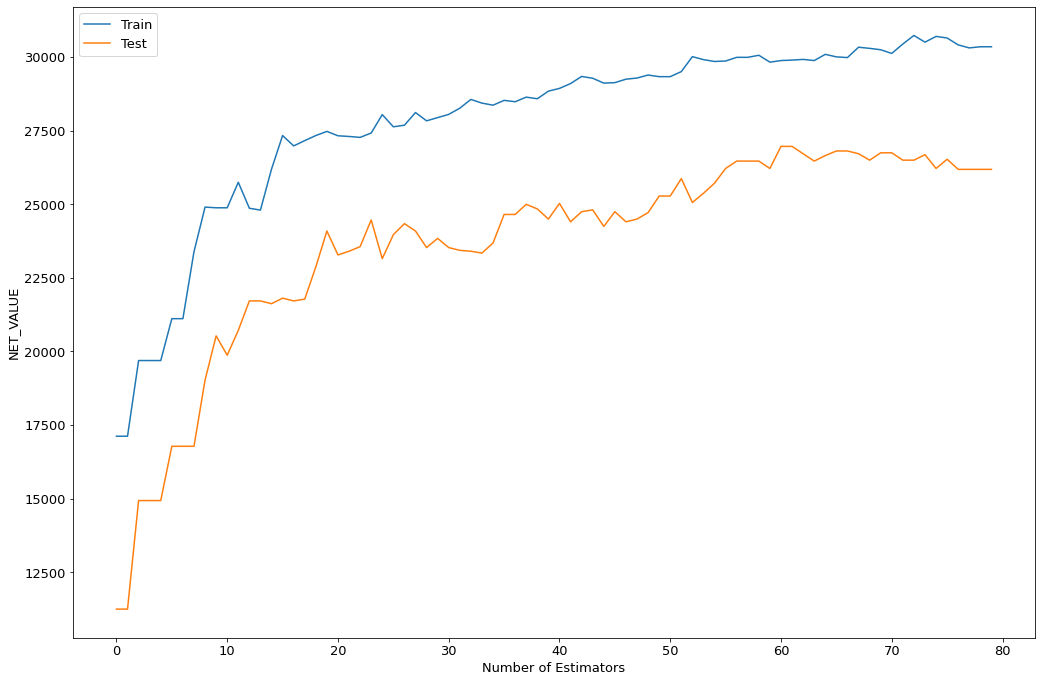

In [53]:
Tot = len(list(xgb_model_tuned.evals_result_['validation_0'].keys()))
Cols = 1
# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols
# Create a Position index
Position = range(1,Tot + 1)

history = xgb_model_tuned.evals_result_
eval_metrics = list(xgb_model_tuned.evals_result_['validation_0'].keys())
x_axis = range(len(history['validation_0'][eval_metrics[0]]))


fig = plt.figure(1, figsize=(15,10))
for k in range(Tot):

  # add every single subplot to the figure with a for loop
  ax = fig.add_subplot(Rows,Cols,Position[k])
  ax.plot(x_axis, history['validation_0'][eval_metrics[k]], label='Train')
  ax.plot(x_axis, history['validation_1'][eval_metrics[k]], label='Test')
  ax.set_xlabel('Number of Estimators')
  ax.set_ylabel(str(eval_metrics[k]).upper())
  l = ax.legend()


fig.tight_layout(pad=2)
plt.show()

In [282]:
y_pred_class_xgb_tuned = xgb_model_tuned.predict(X_test)

In [55]:
y_pred_probs_xgb_tuned = xgb_model_tuned.predict_proba(X_test)

In [284]:
print(classification_report(y_test, y_pred_class_xgb_tuned))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.51      0.81      0.63       376

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [223]:
feature_importances_xgb_tuned = pd.DataFrame({'Model_Importance': xgb_model_tuned.feature_importances_, 'Feature': [x.upper() for x in X_train_no_na.columns]}).sort_values('Model_Importance')
feature_importances_xgb_tuned = feature_importances_xgb_tuned[feature_importances_xgb_tuned['Model_Importance'] > .005]

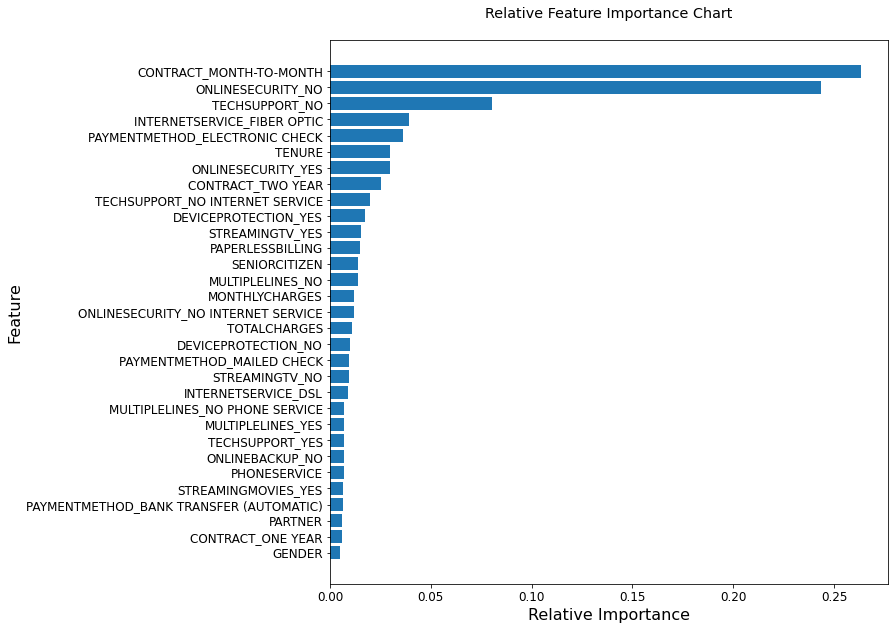

In [224]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 10))
plt.barh(feature_importances_xgb_tuned['Feature'], feature_importances_xgb_tuned['Model_Importance'])
plt.xlabel('Relative Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Relative Feature Importance Chart\n')
plt.show()

#### Random Forest

In [560]:
rf_model_tuned = RandomForestClassifier(**RF_params)

In [561]:
rf_model_tuned.fit(X_train_no_na, y_train_no_na)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=6,
                       min_samples_leaf=4, min_samples_split=8,
                       n_estimators=407)

In [562]:
y_pred_class_rf_tuned = rf_model_tuned.predict(X_test_no_na)

In [54]:
y_pred_probs_rf_tuned = rf_model_tuned.predict_proba(X_test_no_na)

In [564]:
print(classification_report(y_test_no_na, y_pred_class_rf_tuned))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1032
           1       0.50      0.78      0.61       376

    accuracy                           0.74      1408
   macro avg       0.70      0.75      0.71      1408
weighted avg       0.79      0.74      0.75      1408



In [565]:
feature_importances_rf_tuned = pd.DataFrame({'Model_Importance': rf_model_tuned.feature_importances_, 'Feature': [x.upper() for x in X_train_no_na.columns]}).sort_values('Model_Importance')
feature_importances_rf_tuned = feature_importances_rf_tuned[feature_importances_rf_tuned['Model_Importance'] > .005]

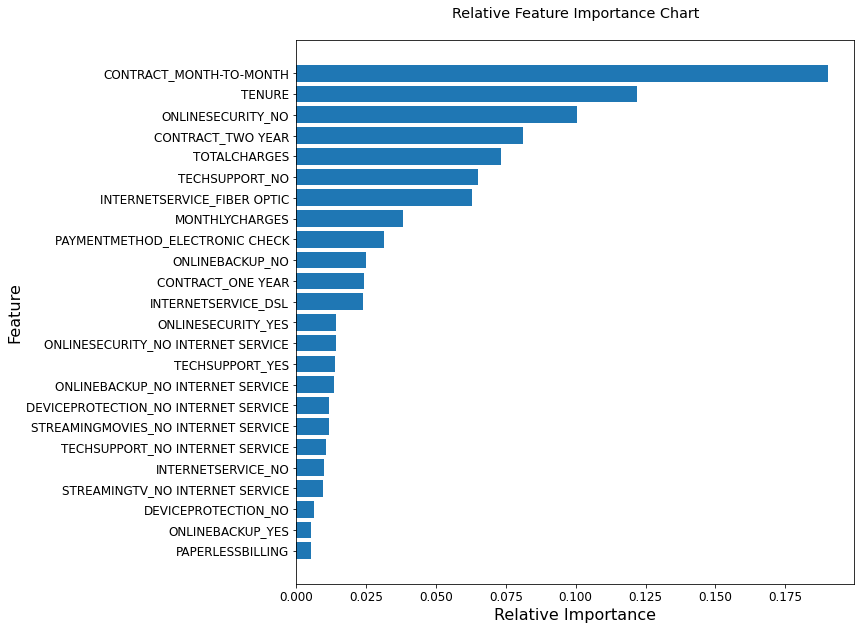

In [566]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 10))
plt.barh(feature_importances_rf_tuned['Feature'], feature_importances_rf_tuned['Model_Importance'])
plt.xlabel('Relative Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Relative Feature Importance Chart\n')
plt.show()

### Combined Model Evaluation

In [56]:
ns_probs = [majority_class for x in range(len(y_test))]

xgb_model_probs_tuned = y_pred_probs_xgb_tuned[:,1]
rf_model_probs_tuned = y_pred_probs_rf_tuned[:,1]

#### ROC Curves

No Skill: ROC AUC=0.500
XGBoost ROC AUC=0.833
Random Forest ROC AUC=0.828


[]

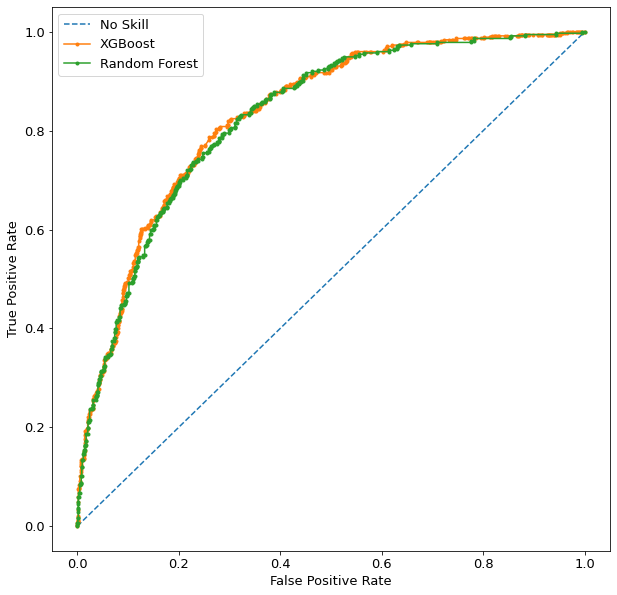

In [57]:
plt.figure(figsize=(10,10))

ns_auc = roc_auc_score(y_test, ns_probs)
xgb_model_auc = roc_auc_score(y_test, xgb_model_probs_tuned)
rf_model_auc = roc_auc_score(y_test_no_na, rf_model_probs_tuned)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost ROC AUC=%.3f' % (xgb_model_auc))
print('Random Forest ROC AUC=%.3f' % (rf_model_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_model_fpr, xgb_model_tpr, _ = roc_curve(y_test, xgb_model_probs_tuned)
rf_model_fpr, rf_model_tpr, _ = roc_curve(y_test_no_na, rf_model_probs_tuned)

plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'No Skill')
plt.plot(xgb_model_fpr,  xgb_model_tpr, marker = '.', label = 'XGBoost')
plt.plot(rf_model_fpr,  rf_model_tpr, marker = '.', label = 'Random Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.plot()

#### Precision-Recall Curves

No Skill: PR AUC=0.267
XGBoost PR AUC=0.636
Random Forest PR AUC=0.627


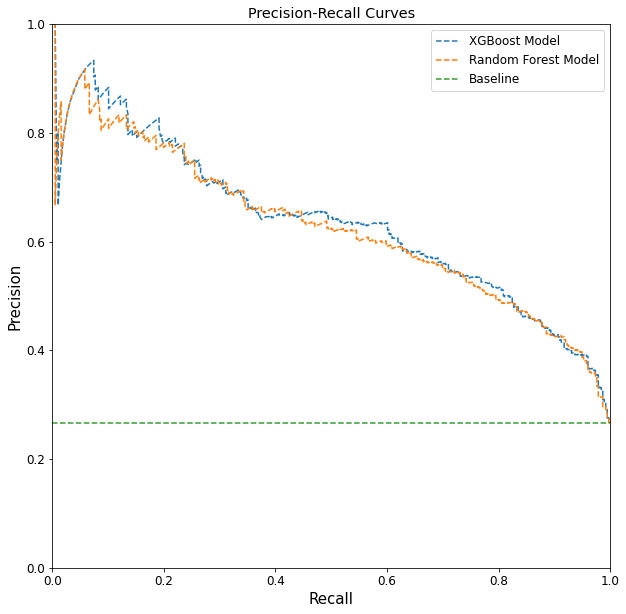

In [569]:
plt.figure(figsize=(10,10))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_model_probs_tuned, pos_label=1)
precision_rf, recall_rf, _ = precision_recall_curve(y_test_no_na, rf_model_probs_tuned, pos_label=1)

no_skill = len(y_test[y_test == 1])/len(y_test)


print('No Skill: PR AUC=%.3f' % (auc([0,1], [no_skill, no_skill])))
print('XGBoost PR AUC=%.3f' % (auc(recall_xgb, precision_xgb)))
print('Random Forest PR AUC=%.3f' % (auc(recall_rf, precision_rf)))

plt.plot(recall_xgb, precision_xgb, linestyle='--', label='XGBoost Model')
plt.plot(recall_rf, precision_rf, linestyle='--', label='Random Forest Model')
plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='Baseline')

plt.xlabel('Recall', size = 15)
plt.ylabel('Precision', size = 15)

plt.title('Precision-Recall Curves')

plt.xlim(0,1)
plt.ylim(0,1)

plt.legend()

plt.show()

## Checkpoint

In this section, we save the dataset (after it has been partitioned into training, development, and test datasets), as well as the customer ID information, the models (both baseline and hyperparameter tuned), and the actual hyperparameters which are used in the hyperparameter tuned models.

In [46]:
drive.mount('/content/drive')

Mounted at /content/drive


### Save Data

In [61]:
# !mkdir content/drive2/MyDrive/Toy_DS_Project

In [830]:
pickle.dump(X_train, open("/content/drive/MyDrive/Toy_DS_Project/X_train", 'wb'))
pickle.dump(X_dev, open("/content/drive/MyDrive/Toy_DS_Project/X_dev", 'wb'))
pickle.dump(X_test, open("/content/drive/MyDrive/Toy_DS_Project/X_test", 'wb'))
pickle.dump(y_train, open("/content/drive/MyDrive/Toy_DS_Project/y_train", 'wb'))
pickle.dump(y_dev, open("/content/drive/MyDrive/Toy_DS_Project/y_dev", 'wb'))
pickle.dump(y_test, open("/content/drive/MyDrive/Toy_DS_Project/y_test", 'wb'))

In [831]:
pickle.dump(X_train_no_na, open("/content/drive/MyDrive/Toy_DS_Project/X_train_no_na", 'wb'))
pickle.dump(y_train_no_na, open("/content/drive/MyDrive/Toy_DS_Project/y_train_no_na", 'wb'))
pickle.dump(X_dev_no_na, open("/content/drive/MyDrive/Toy_DS_Project/X_dev_no_na", 'wb'))
pickle.dump(y_dev_no_na, open("/content/drive/MyDrive/Toy_DS_Project/y_dev_no_na", 'wb'))
pickle.dump(X_test_no_na, open("/content/drive/MyDrive/Toy_DS_Project/X_test_no_na", 'wb'))
pickle.dump(y_test_no_na, open("/content/drive/MyDrive/Toy_DS_Project/y_test_no_na", 'wb'))

In [832]:
pickle.dump(X_train_IDs, open("/content/drive/MyDrive/Toy_DS_Project/X_train_IDs", 'wb'))
pickle.dump(X_dev_IDs, open("/content/drive/MyDrive/Toy_DS_Project/X_dev_IDs", 'wb'))
pickle.dump(X_test_IDs, open("/content/drive/MyDrive/Toy_DS_Project/X_test_IDs", 'wb'))

In [833]:
pickle.dump(XGB_params, open("/content/drive/MyDrive/Toy_DS_Project/XGB_params", 'wb'))
pickle.dump(RF_params, open("/content/drive/MyDrive/Toy_DS_Project/RF_params", 'wb'))

In [834]:
pickle.dump(xgb_model, open("/content/drive/MyDrive/Toy_DS_Project/xgb_model", 'wb'))
pickle.dump(rf_model, open("/content/drive/MyDrive/Toy_DS_Project/rf_model", 'wb'))
pickle.dump(xgb_model_tuned, open("/content/drive/MyDrive/Toy_DS_Project/xgb_model_tuned", 'wb'))
pickle.dump(rf_model_tuned, open("/content/drive/MyDrive/Toy_DS_Project/rf_model_tuned", 'wb'))

### Load Data

In [47]:
X_train = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/X_train", 'rb'))
X_dev = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/X_dev", 'rb'))
X_test = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/X_test", 'rb'))
y_train = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/y_train", 'rb'))
y_dev = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/y_dev", 'rb'))
y_test = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/y_test", 'rb'))

In [48]:
X_train_no_na = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/X_train_no_na", 'rb'))
y_train_no_na = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/y_train_no_na", 'rb'))
X_dev_no_na = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/X_dev_no_na", 'rb'))
y_dev_no_na = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/y_dev_no_na", 'rb'))
X_test_no_na = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/X_test_no_na", 'rb'))
y_test_no_na = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/y_test_no_na", 'rb'))

In [49]:
X_train_IDs = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/X_train_IDs", 'rb'))
X_dev_IDs = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/X_dev_IDs", 'rb'))
X_test_IDs = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/X_test_IDs", 'rb'))

In [50]:
XGB_params = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/XGB_params", 'rb'))
RF_params = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/RF_params", 'rb'))

In [130]:
xgb_model = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/xgb_model", 'rb'))
rf_model = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/rf_model", 'rb'))
xgb_model_tuned = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/xgb_model_tuned", 'rb'))
rf_model_tuned = pickle.load(open("/content/drive/MyDrive/Toy_DS_Project/rf_model_tuned", 'rb'))

# Economic Framework

In this section, we explore the economic framework which has been touched upon earlier in greater detail. Specifically, since the net value function has two variables which are related to model performance (i.e., churn prediction precision and volume), we are able to plot that function in three dimensions where two dimensions are related to model performance and the third dimension is the output of the function: net value. We first evaluate that function over a wide range of hypothetical model performance values and produce the corresponding net value amoutns to create a 3-dimensional surface. This surface allows us to quickly get a sense of the economic viability of the model given the structure of the tactic and the assumptions around the effectiveness and economics of that tactic. We then overlay a line for each of the models that we have trained so we can understand how different model performance values will translate to economic value, as well as how those models compare to each other. Generally speaking, the goal is to develop models which "climb" the surface of the 3-dimensional plot. Additionally, on each of the lines which represent a model, the highest point on the line corresponds to the combination of model churn prediction precision and volume that achieves maximum net value. There is also a line for a "no-skill" model which provides a sense for the extent to which our models are providing benefit above that which could be achieved if we simply predicted all customer to churn. In most instances, the difference between trained models (in terms of net value) will be significant (and the point on the no-skill model line will indicate that the most optimal volume is 0 customers); however, depending on the economics of the tactic, it could be possible that is economically optimal to extend a tactic to all customers. Such a situation could arise for exceptionally cheap and effective tactics which can employed at scale. Lastly, one of the benefits of this framework is that we can also extract the classification threshold which is associated with the highest net value (i.e., the highest point on the line).

Also, revisiting the topic of hyperparameter tuning, below the 3-dimensional plot there is a dataframe which summmarizes the relevant information. Here we can see that the difference between the tuned XGBoost model and the baseline XGBoost model represents an percent increase of over 8%. When we look at the increase in performance that we observed in area under the ROC and Precision Recall curves, the difference was well under 1%. The same situation is true with the Random Forest model but to an even greater degree. Using conventional metrics, we saw a percent increase of under 6%. When we look at the improvement in net value, the percent increase is over 23%!

Of note, this plot is interactive so it can be dragged around to obtain different perspectives.

## Helper Functions

In [58]:
def evaluate_model_across_thresholds(model, X_test, y_test, starting_threshold=.5, ending_threshold=.5):
    probs = model.predict_proba(X_test)
    model_outputs = []
    for i in range(int(starting_threshold*100), int(ending_threshold*100)+1, 1):
        i = i/100
        y_bin = (probs[:,1] > i).astype(int)
        TN, FP, FN, TP = confusion_matrix(y_test, y_bin, labels=[0, 1]).ravel()
        accuracy = (TP+TN)/(TP+TN+FP+FN)
        if FP == 0 & TP == 0:
            precision = 0
        else:
            precision = TP/(FP+TP)
        recall = TP/(FN+TP)
        f1 = TP/(TP + (0.5*(FP+FN)))
        model_outputs.append([i, TP, FP, TN, FN, accuracy, precision, recall, f1])
    model_outputs = pd.DataFrame(model_outputs, columns = ['CLASSIFICATION_THRESHOLD', 'TRUE_POSITIVES', 'FALSE_POSITIVES', 'TRUE_NEGATIVES', 'FALSE_NEGATIVES', 'ACCURACY', 'PRECISION', 'RECALL', 'F1'])
    return model_outputs

In [97]:
def economic_framework(list_of_models, 
                       list_of_model_names, 
                       net_value_function, 
                       economic_assumptions, 
                       X_test, 
                       y_test, 
                       size_of_target_audience_min, 
                       size_of_target_audience_max, 
                       starting_threshold = .1, 
                       ending_threshold = .95, 
                       min_precision = 0,
                       max_precision = 1):
    
    # Getting X and Y Components for 3D Shape
    GRID_CHURN_PRECISION = np.arange(min_precision, max_precision, .025)
    GRID_CHURN_VOLUME = np.arange(size_of_target_audience_min, size_of_target_audience_max, size_of_target_audience_max/(size_of_target_audience_max/100))
    
    # Getting Z Component for 3D Shape
    X,Y = meshgrid(GRID_CHURN_PRECISION, GRID_CHURN_VOLUME)
    GRID_NET_VALUE = net_value_function(X, Y, **economic_assumptions)

    # Getting Extreme Net Value Points
    MAX_NET_VALUE = net_value_function(max_precision, size_of_target_audience_max, **economic_assumptions)
    MIN_NET_VALUE = net_value_function(min_precision, size_of_target_audience_max, **economic_assumptions)

    # Taking the greater of the 2 extreme points in order to make colormap symmetrical around 0 net value
    MAX_SCALE = max(abs(MIN_NET_VALUE), abs(MAX_NET_VALUE))

    # Making 3D Surface
    fig = plt.figure(1, figsize=(20,12))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, GRID_NET_VALUE, rstride=1, cstride=1, cmap=cm.RdBu, linewidth = 0, antialiased=True, vmin = MAX_SCALE*-1, vmax=MAX_SCALE, alpha = .7)

    SUMMARY_DF_LIST = []

    # Plotting Range of Possible Net Values (and Max Net Value) for Each Model
    counter = 0
    for i in range(len(list_of_models)):
        try:
            TUNED_THRESHOLD_DF = evaluate_model_across_thresholds(list_of_models[i], X_test, y_test, starting_threshold, ending_threshold)
        except:
            X_test_no_na_index = X_test.isnull().any(axis=1)
            X_test_no_na = X_test[~X_test_no_na_index]
            y_test_no_na = y_test[~X_test_no_na_index]      
            TUNED_THRESHOLD_DF = evaluate_model_across_thresholds(list_of_models[i], X_test_no_na, y_test_no_na, starting_threshold, ending_threshold)

        CHURN_PRECISION_VALUES_WITH_MODEL = list(TUNED_THRESHOLD_DF['PRECISION'])
        CHURN_PREDICTION_VOLUME_WITH_MODEL = np.array(TUNED_THRESHOLD_DF['TRUE_POSITIVES'] + TUNED_THRESHOLD_DF['FALSE_POSITIVES']) / (len(y_test)/size_of_target_audience_max)
        NET_VALUES_WITH_MODEL = (net_value_function(np.asarray(CHURN_PRECISION_VALUES_WITH_MODEL), np.asarray(CHURN_PREDICTION_VOLUME_WITH_MODEL), **economic_assumptions))
        MAX_NET_INDEX_WITH_MODEL = np.argmax(NET_VALUES_WITH_MODEL)

        OPTIMAL_CLASSIFICATION_THRESHOLD = TUNED_THRESHOLD_DF['CLASSIFICATION_THRESHOLD'].iloc[MAX_NET_INDEX_WITH_MODEL]
        OPTIMAL_PRECISION = CHURN_PRECISION_VALUES_WITH_MODEL[MAX_NET_INDEX_WITH_MODEL]
        OPTIMAL_CHURN_PREDICTION_VOLUME = CHURN_PREDICTION_VOLUME_WITH_MODEL[MAX_NET_INDEX_WITH_MODEL]
        MAXIMUM_NET_VALUE_ACHIEVABLE = NET_VALUES_WITH_MODEL[MAX_NET_INDEX_WITH_MODEL]

        TRUE_POSITIVES_EXPECTED = round(OPTIMAL_PRECISION * OPTIMAL_CHURN_PREDICTION_VOLUME)
        FALSE_POSITIVES_EXPECTED = round((1-OPTIMAL_PRECISION) * OPTIMAL_CHURN_PREDICTION_VOLUME)

        ax.plot(np.asarray(CHURN_PRECISION_VALUES_WITH_MODEL), np.asarray(CHURN_PREDICTION_VOLUME_WITH_MODEL), NET_VALUES_WITH_MODEL, label=' '.join(list_of_model_names[i].split(' \ ')))
        ax.plot(np.asarray([OPTIMAL_PRECISION]), 
                np.asarray([OPTIMAL_CHURN_PREDICTION_VOLUME]), 
                np.asarray([MAXIMUM_NET_VALUE_ACHIEVABLE]), 
                marker='o',
                markersize = 5,
                markerfacecolor = ax.get_lines()[i+counter].get_color(),
                markeredgecolor = ax.get_lines()[i+counter].get_color()
                )
        counter += 1

        SUMMARY_DF_LIST.append([list_of_model_names[i], OPTIMAL_CLASSIFICATION_THRESHOLD, round(OPTIMAL_PRECISION,2), 
                                round(OPTIMAL_CHURN_PREDICTION_VOLUME), TRUE_POSITIVES_EXPECTED, FALSE_POSITIVES_EXPECTED, round(MAXIMUM_NET_VALUE_ACHIEVABLE)])
    
    clb = fig.colorbar(surf, shrink=.5, aspect=5)
    clb.set_label('Net Value', labelpad = -40, y=1.1, rotation=0)



    # Plotting No-Skill Model
    TP = TUNED_THRESHOLD_DF.iloc[0]['TRUE_POSITIVES']
    FP = TUNED_THRESHOLD_DF.iloc[0]['FALSE_POSITIVES']
    TN = TUNED_THRESHOLD_DF.iloc[0]['TRUE_NEGATIVES']
    FN = TUNED_THRESHOLD_DF.iloc[0]['FALSE_NEGATIVES']
    PRECISION_NS_MODEL = (TP+FN)/(TP+FP+TN+FN)

    CHURN_PREDICTION_VOLUME_WITH_NS_MODEL = list(np.arange(0, size_of_target_audience_max, size_of_target_audience_max/10))
    CHURN_PRECISION_VALUES_WITH_NS_MODEL = [PRECISION_NS_MODEL]*len(CHURN_PREDICTION_VOLUME_WITH_NS_MODEL)

    NET_VALUES_WITH_NS_MODEL = (net_value_function(np.asarray(CHURN_PRECISION_VALUES_WITH_NS_MODEL), np.asarray(CHURN_PREDICTION_VOLUME_WITH_NS_MODEL), **economic_assumptions))
    MAX_NET_INDEX_WITH_NS_MODEL = np.argmax(NET_VALUES_WITH_NS_MODEL)

    OPTIMAL_PRECISION_NS = CHURN_PRECISION_VALUES_WITH_NS_MODEL[MAX_NET_INDEX_WITH_NS_MODEL]
    OPTIMAL_CHURN_PREDICTION_VOLUME_NS = CHURN_PREDICTION_VOLUME_WITH_NS_MODEL[MAX_NET_INDEX_WITH_NS_MODEL]
    MAXIMUM_NET_VALUE_ACHIEVABLE_NS = NET_VALUES_WITH_NS_MODEL[MAX_NET_INDEX_WITH_NS_MODEL]

    TRUE_POSITIVES_EXPECTED = round(OPTIMAL_PRECISION_NS * OPTIMAL_CHURN_PREDICTION_VOLUME_NS)
    FALSE_POSITIVES_EXPECTED = round((1-OPTIMAL_PRECISION_NS) * OPTIMAL_CHURN_PREDICTION_VOLUME_NS)

    ax.plot(np.asarray(CHURN_PRECISION_VALUES_WITH_NS_MODEL), np.asarray(CHURN_PREDICTION_VOLUME_WITH_NS_MODEL), NET_VALUES_WITH_NS_MODEL, color='black', label='No Skill Model')
    ax.plot(np.asarray([OPTIMAL_PRECISION_NS]), 
            np.asarray([OPTIMAL_CHURN_PREDICTION_VOLUME_NS]), 
            np.asarray([MAXIMUM_NET_VALUE_ACHIEVABLE_NS]), 
            marker='o',
            markersize = 5,
            markerfacecolor = 'black',
            markeredgecolor = 'black'
            )
    

    SUMMARY_DF_LIST.append(['No \ Skill \ Model', np.nan, round(OPTIMAL_PRECISION_NS,2), round(OPTIMAL_CHURN_PREDICTION_VOLUME_NS), TRUE_POSITIVES_EXPECTED, FALSE_POSITIVES_EXPECTED, round(MAXIMUM_NET_VALUE_ACHIEVABLE_NS)])

    SUMMARY_DF = pd.DataFrame(SUMMARY_DF_LIST, columns=['MODEL', 'OPTIMAL_CLASSIFICATION_THRESHOLD', 'ASSOCIATED_PRECISION', 'ASSOCIATED_CHURN_PREDICTION_VOLUME',
                                                        'TRUE_POSITIVES_EXPECTED', 'FALSE_POSITIVES_EXPECTED', 'EXPECTED_NET_VALUE']).sort_values('EXPECTED_NET_VALUE', ascending=False)


    # Creating Text Fields
    MAX_NET_VALUE_ACHIEVABLE_WITH_MODEL = SUMMARY_DF['EXPECTED_NET_VALUE'].sort_values(ascending=False).iloc[0]
    MIN_NET_VALUE_ACHIEVABLE_WITH_MODEL = SUMMARY_DF['EXPECTED_NET_VALUE'].sort_values().iloc[0]
    MAX_NET_VALUE_ACHIEVABLE_WITH_NS_MODEL = NET_VALUES_WITH_NS_MODEL[MAX_NET_INDEX_WITH_NS_MODEL]



    ASSUMPTION_TEST = r"$\bf{"+'Scenario \ Parameters/Assumptions:'+"}$"+'\
    \n Cost of Outbound Call: ${COST_OF_OUTBOUND_CALL} \
    \n Probability of True Positive Taking Offer: {PROBABILITY_OF_TP_TAKING_TACTIC}% \
    \n Average Value of Improved Retention Due to Tactic: ${VALUE_OF_IMPROVED_RETENTION_DUE_TO_TACTIC} \
    \n Cost Associated with Customer Accepting Offer: ${COST_OF_CUSTOMER_TAKING_TACTIC} \
    \n Probability of False Positive Taking Offer: {PROBABILITY_OF_FP_TAKING_TACTIC}% \
    \n Additional Fixed Costs: ${ADDITIONAL_FIXED_COSTS_OVER_TIMEFRAME}'.format(COST_OF_OUTBOUND_CALL = "{:,}".format(economic_assumptions['COST_OF_OUTBOUND_CALL']),
                                                                                PROBABILITY_OF_TP_TAKING_TACTIC = economic_assumptions['PROBABILITY_OF_TP_TAKING_TACTIC']*100,
                                                                                VALUE_OF_IMPROVED_RETENTION_DUE_TO_TACTIC = "{:,}".format(economic_assumptions['VALUE_OF_IMPROVED_RETENTION_DUE_TO_TACTIC']),
                                                                                COST_OF_CUSTOMER_TAKING_TACTIC = "{:,}".format(economic_assumptions['COST_OF_CUSTOMER_TAKING_TACTIC']),
                                                                                PROBABILITY_OF_FP_TAKING_TACTIC =economic_assumptions['PROBABILITY_OF_FP_TAKING_TACTIC']*100,
                                                                                ADDITIONAL_FIXED_COSTS_OVER_TIMEFRAME = "{:,}".format(economic_assumptions['ADDITIONAL_FIXED_COSTS_OVER_TIMEFRAME']))




    MAX_NET_VALUE_TEXT = 'Maximum \ Net \ Value \ Achievable \ with \ Optimal \ Model \ ({OPTIMAL_MODEL}) \ and \ Given \ Tactic \ Assumptions: \${MAX_NET_VALUE_ACHIEVABLE_WITH_MODEL} \ (Lift \ Over: \ No-Skill \ Model \ (Black): \ {NET_DIFF})'.format(
        OPTIMAL_MODEL = SUMMARY_DF['MODEL'].iloc[0], 
        MAX_NET_VALUE_ACHIEVABLE_WITH_MODEL = round(MAX_NET_VALUE_ACHIEVABLE_WITH_MODEL, 1),
        NET_DIFF = round(MAX_NET_VALUE_ACHIEVABLE_WITH_MODEL - MAX_NET_VALUE_ACHIEVABLE_WITH_NS_MODEL, 1),
    )

    economic_assumptions_temp = economic_assumptions.copy()
    del economic_assumptions_temp['ADDITIONAL_FIXED_COSTS_OVER_TIMEFRAME']

    BREAKEVEN_MODEL_PRECISION = breakeven_model_precision_excluding_fixed_costs(**economic_assumptions_temp)

    BREAKEVEN_TEXT = 'Breakeven \ Model \ Precision \ (with \ Respect \ to \ Churn \ Classifications) \ Excluding \ Fixed \ Costs: {BREAKEVEN_MODEL_PRECISION}\% \ ; No-Skill \ Model: {NS_CHURN_PRECISION}\%'.format(
        BREAKEVEN_MODEL_PRECISION = round(BREAKEVEN_MODEL_PRECISION*100, 2),
        NS_CHURN_PRECISION = round(PRECISION_NS_MODEL*100, 2)
    )


    fig.suptitle('Economic Framework - Understanding the Net Value Achievable with a Model-Driven Retention Tactic', fontsize=19)

    fig.text(.5, .93, ASSUMPTION_TEST, ha='center', va='top', fontsize=14)

    fig.text(.52, .07, r"$\bf{"+MAX_NET_VALUE_TEXT+"}$", ha='center', va='bottom', fontsize=14)

    fig.text(.51, .1, r"$\bf{"+BREAKEVEN_TEXT+"}$", ha='center', va='bottom', fontsize=14)

    # Finishing Touches
    ax.set_xlabel('Model Positive Predictive Value')
    ax.set_ylabel('Customers Predicted to Churn')
    ax.set_zlabel('Net Value Over Timeframe')
    ax.zaxis.set_major_locator(LinearLocator(10))
    plt.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=14)                       
    plt.show()

    SUMMARY_DF['MODEL'] = SUMMARY_DF['MODEL'].apply(lambda x: ' '.join(x.split(' \ ')))


    return SUMMARY_DF

In [98]:
output.enable_custom_widget_manager()

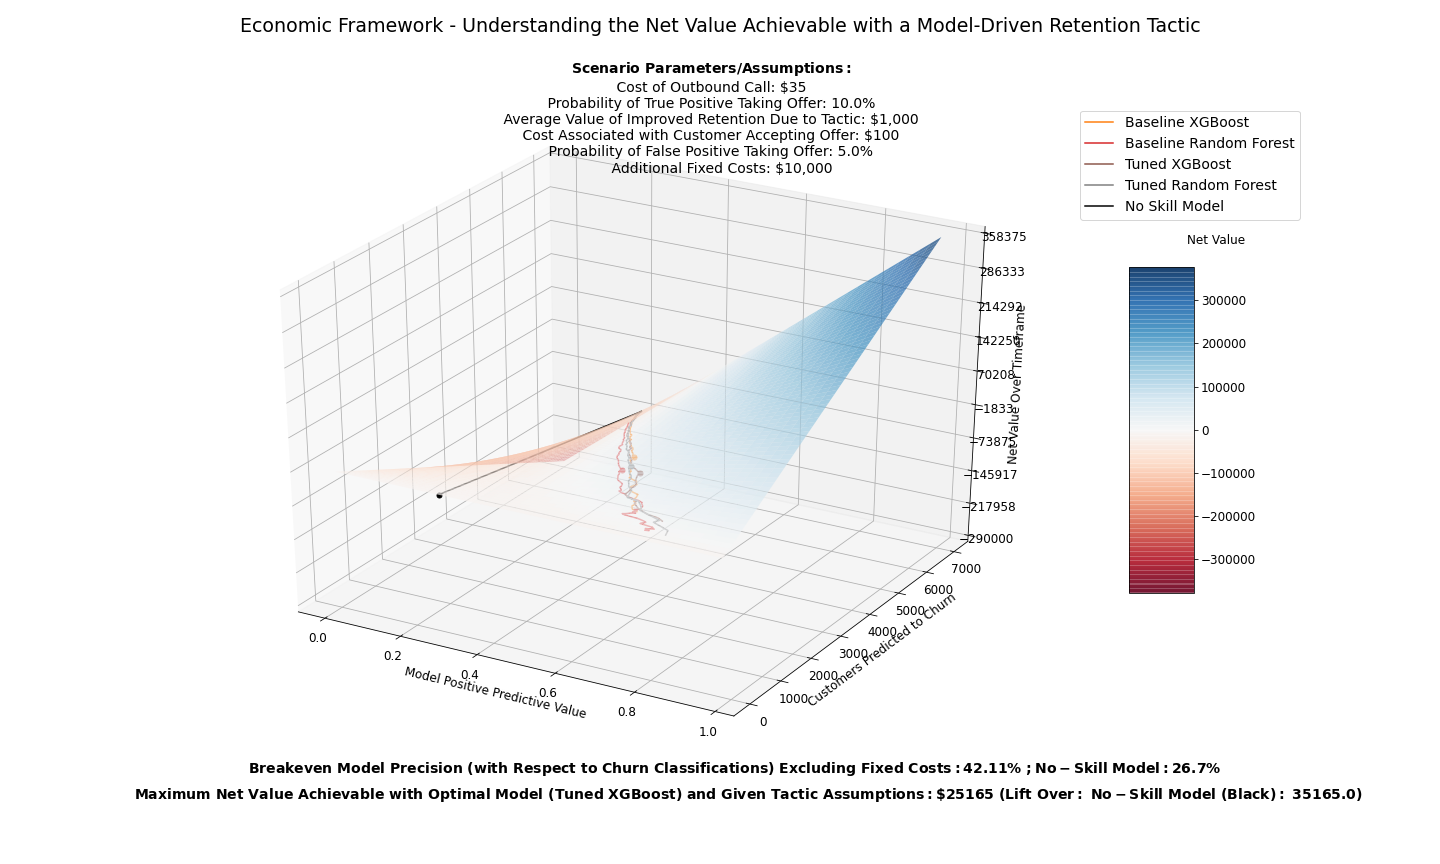

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 0.8999999761581421}


In [99]:
%matplotlib widget

list_of_models = [xgb_model, rf_model, xgb_model_tuned, rf_model_tuned]
list_of_model_names = ['Baseline \ XGBoost', 'Baseline \ Random \ Forest', 'Tuned \ XGBoost', 'Tuned \ Random \ Forest']

SUMMARY_DF = economic_framework(list_of_models, list_of_model_names, net_value_function, economic_assumptions,
                                    X_test, y_test, 0, len(df), starting_threshold = .1, ending_threshold = .85, min_precision = 0, max_precision = 1)

In [842]:
SUMMARY_DF

MODEL  ...  EXPECTED_NET_VALUE
2           Tuned XGBoost  ...               25165
0        Baseline XGBoost  ...               22991
3     Tuned Random Forest  ...               22091
1  Baseline Random Forest  ...               17917
4          No Skill Model  ...              -10000

[5 rows x 7 columns]

In [818]:
# Resetting matplotlib back to inline mode when done with interacting with 3D plot (or else plots will continue to display interactively (and overlap) as they are created)
%matplotlib inline

# Simulated Experiment

In this final section, we simulate an experiment which might typically be required in a business setting in order to better understand the impact of the model and the tactics being driven by it before moving forward with full scale implementation. It is also useful to assess for whether or not, based on the analysis of the data that we have conducted thus far, if there is a specific target audience and/or pain point which could be specifically addressed as part of this proactive retention tactic. What we can see by looking at the data is that customers who are on a month-to-month contract have a greater propensity to churn. For that reason, a possible tactic might be to offer a financial incentive (perhaps of varying magnitudes) if the customer switches to a one-year or two-year contract.

When we assess for the economic viability of using the model to target these kinds of customers, in particular, we can see that the output of the model is very similar, which indicates that most of the customers who are predicted to churn when we run the model on the full dataset are likely customers who are on the month-to-month contract. In any event, the economic picture remains largely unchanged, with the targeted approach indicating slightly more upside from a net value perspective. 

## Selection of Population of Interest

In [115]:
df.groupby('Contract_Month-to-month')['customerID'].count()

Contract_Month-to-month
0    3168
1    3875
Name: customerID, dtype: int64

In [116]:
POPULATION_OF_INTEREST = df[df['Contract_Month-to-month'] == 1]
POPULATION_OF_INTEREST.groupby('Churn')['customerID'].count()/len(POPULATION_OF_INTEREST)

Churn
0    0.572903
1    0.427097
Name: customerID, dtype: float64

In [117]:
len(POPULATION_OF_INTEREST)

3875

In [118]:

df[df['Contract_Month-to-month'] == 0].groupby('Churn')['customerID'].count()/len(df[df['Contract_Month-to-month'] == 0])

Churn
0    0.932449
1    0.067551
Name: customerID, dtype: float64

In [119]:
X_test_M2M_index = X_test['Contract_Month-to-month'] == 1
X_test_M2M = X_test[X_test_M2M_index]
y_test_M2M = y_test[X_test_M2M_index]

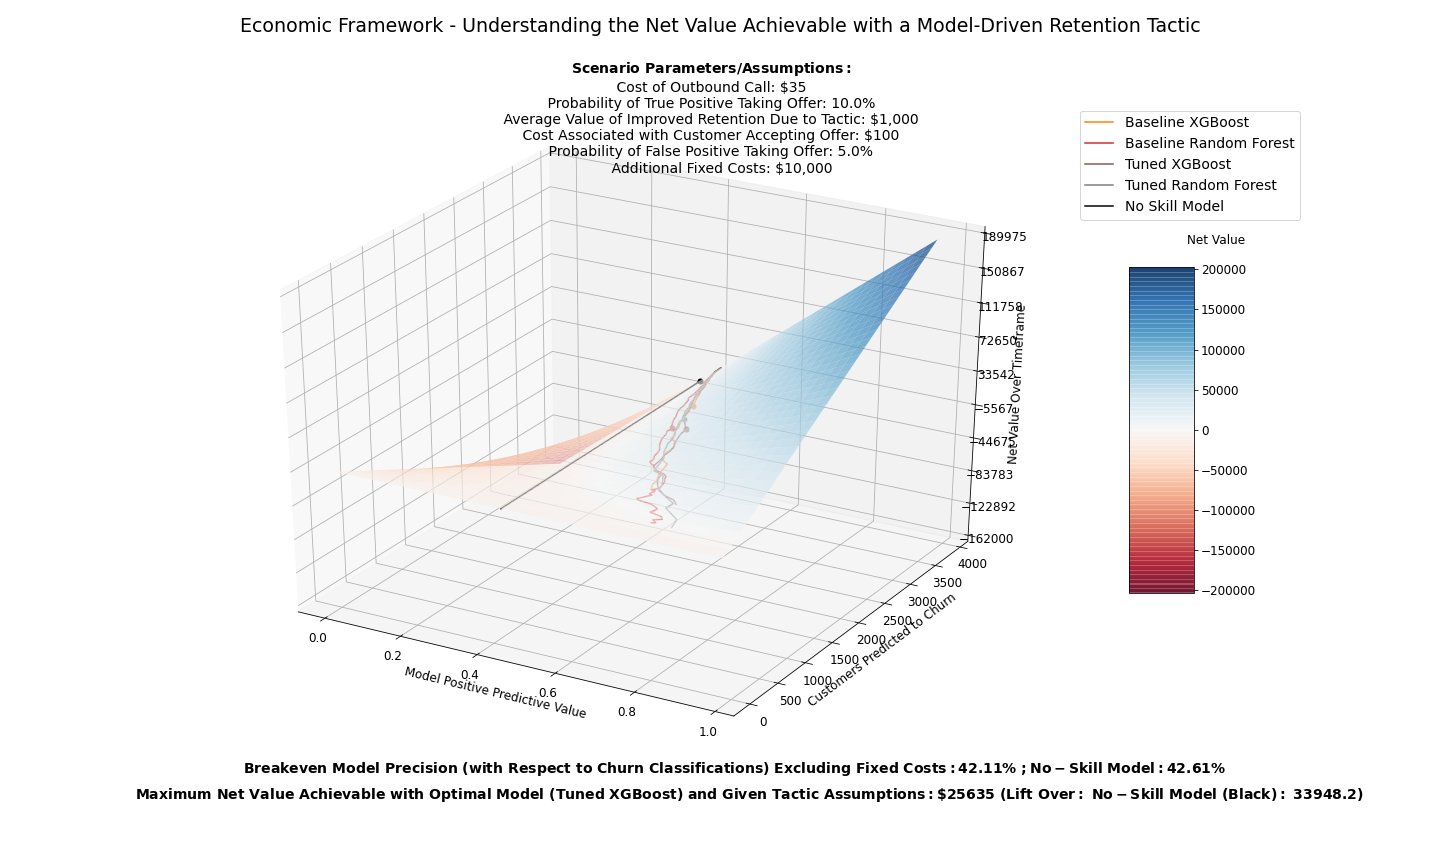

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 0.8999999761581421}


In [123]:
%matplotlib widget

list_of_models = [xgb_model, rf_model, xgb_model_tuned, rf_model_tuned]
list_of_model_names = ['Baseline \ XGBoost', 'Baseline \ Random \ Forest', 'Tuned \ XGBoost', 'Tuned \ Random \ Forest']

SUMMARY_DF_M2M = economic_framework(list_of_models, list_of_model_names, net_value_function, economic_assumptions,
                                    X_test_M2M, y_test_M2M, 0, len(df[df['Contract_Month-to-month'] == 1]), starting_threshold = .1, ending_threshold = .85, min_precision = 0, max_precision = 1)

In [124]:
SUMMARY_DF_M2M.reset_index(drop=True)

MODEL  ...  EXPECTED_NET_VALUE
0           Tuned XGBoost  ...               25635
1        Baseline XGBoost  ...               23077
2     Tuned Random Forest  ...               22520
3  Baseline Random Forest  ...               19025
4          No Skill Model  ...               -8313

[5 rows x 7 columns]

In [125]:
# Resetting matplotlib back to inline mode when done with interacting with 3D plot (or else plots will continue to display interactively (and overlap) as they are created)
%matplotlib inline

## Power Analysis

At this point, we now need to conduct a power analysis to ensure that the test will be adequately powered (i.e., have enough observations going to both the test and control groups) such that there will be a high likelihood of observing the treatment effect in a statistically significant way (should such an effect exist). To do that, insert a range of values for alpha (a measure of statistical significant) and beta (a measure of statistical power) to evaluate the different sizes of the test. In terms of the hypothesized effect size, in this case we will stick with the 10% which is utilized in the economic framework. Typically, this value would ideally be derived from existing analyses or could represent the lowest effect size that the business is even interested in being able to observe; however, in this case, we will stick with 10%.

Since, in this case, we are only interested in measuring churn, we do not utilize a Bonferroni Correction Factor. In instances where we would desire to perform multiple measurements on the same dataset, particularly if the measurements are related in some way, applying this correction factor has the effect of minimizing the alpha value such that we are not artificially increasing the probability of a type 1 error (i.e., observing a statistically significant finding when there is no real treatment effect). Also included in the power analysis is information around the duration of the test for a given number of calls which would need to be placed. This is simply based on assumptions around the number of phone reps who would participate and the call throughput those reps could generate. 

Finally, another limitation in this power analysis pertains to the size of the target audience. We may have the phone representative capacity to place a large number of call, as well as the business appetite to run the test for an extended period (such that small effects could be observed and/or type 1 and type 2 risks could be minimized). However, if the size of the target audience is too small, we be limited in the number of calls we can place for that reason. When we look at the expected volume of churn predictions given the optimal classification threshold, this does turn out to the be case given the assumed phone rep capacity. For that reason, we elect to power the experiment such that with ~750 customers placed in both the test and control groups, the experiment would be 80% likely to observe the hypothesized effect (should it exist at and exist at that level) and have a 10% probability of observing a statistically significant effect which does not actually exist (i.e., a false positive). These statistical parameters are ultimately a reflection on the risk levels the business has an appetite to accept, as well as the size of the effect which is hypothesized/needs to be observed. However, in this context, these statistical parameters would seem reasonable.

In [133]:
# X_FOR_INFERENCE = POPULATION_OF_INTEREST.drop('Churn', axis=1).reset_index(drop=True)
X_INFERENCE_IDS = POPULATION_OF_INTEREST['customerID']
X_FOR_INFERENCE = POPULATION_OF_INTEREST.drop(['customerID', 'Churn'], axis=1).reset_index(drop=True)

In [134]:
EXPERIMENT_PROBABILITIES = xgb_model_tuned.predict_proba(X_FOR_INFERENCE)
EXPERIMENT_PREDICTIONS = (EXPERIMENT_PROBABILITIES[:,1] > SUMMARY_DF_M2M[SUMMARY_DF_M2M['MODEL'] == 'Tuned XGBoost']['OPTIMAL_CLASSIFICATION_THRESHOLD'].iloc[0]).astype(int)

In [135]:
EXPERIMENT_DF = pd.DataFrame({'Customer_ID': X_INFERENCE_IDS,
                              'Churn_Probability': EXPERIMENT_PROBABILITIES[:,1],
                              'Churn_Predictions': EXPERIMENT_PREDICTIONS})
EXPERIMENT_DF

Customer_ID  Churn_Probability  Churn_Predictions
0     7590-VHVEG           0.813285                  1
2     3668-QPYBK           0.540681                  0
4     9237-HQITU           0.855648                  1
5     9305-CDSKC           0.903077                  1
6     1452-KIOVK           0.670614                  0
...          ...                ...                ...
7033  9767-FFLEM           0.569563                  0
7034  0639-TSIQW           0.512774                  0
7035  8456-QDAVC           0.671400                  0
7040  4801-JZAZL           0.587956                  0
7041  8361-LTMKD           0.851699                  1

[3875 rows x 3 columns]

In [136]:
NUMBER_OF_PHONE_REPS = 10
CALLS_PER_REP_PER_DAY = 12
DAILY_CALLS = NUMBER_OF_PHONE_REPS * CALLS_PER_REP_PER_DAY
NUMBER_OF_CALLING_DAYS_IN_MONTH = 22

MAXIMUM_CUSTOMERS_AVAILABLE_TO_CALL = int(np.floor(EXPERIMENT_DF['Churn_Predictions'].sum()/2))

BFC = 1

# ATTRITION_RATE_BASELINE = POPULATION_OF_INTEREST['Churn'].sum()/len(POPULATION_OF_INTEREST)

ATTRITION_RATE_MODEL_OUTPUT = SUMMARY_DF_M2M[SUMMARY_DF_M2M['MODEL'] == 'Tuned XGBoost']['ASSOCIATED_PRECISION'].iloc[0]
PROBABILITY_OF_RETAINING_TP_DUE_TO_TREATMENT = economic_assumptions['PROBABILITY_OF_TP_TAKING_TACTIC']

# Proportion of true positives who cancel (i.e., model precision) is reduced by the number of true positives who are positively affected by the treatment and don't cancel
HYPOTHESIZED_ATTRITION_RATE_OF_TEST_GROUP = ATTRITION_RATE_MODEL_OUTPUT - (ATTRITION_RATE_MODEL_OUTPUT * PROBABILITY_OF_RETAINING_TP_DUE_TO_TREATMENT) 

DIFFERENCE_BETWEEN_GROUPS_PERCENTAGE_POINTS = ATTRITION_RATE_MODEL_OUTPUT - HYPOTHESIZED_ATTRITION_RATE_OF_TEST_GROUP
DIFFERENCE_BETWEEN_GROUPS_PERCENT_CHANGE = (HYPOTHESIZED_ATTRITION_RATE_OF_TEST_GROUP - ATTRITION_RATE_MODEL_OUTPUT)/ATTRITION_RATE_MODEL_OUTPUT

HYPOTHESIZED_EFFECT_SIZE = 2*np.arcsin(np.sqrt(ATTRITION_RATE_MODEL_OUTPUT)) - 2*np.arcsin(np.sqrt(HYPOTHESIZED_ATTRITION_RATE_OF_TEST_GROUP))

ALPHA_LIST = [.05, .1, .15, .2]
POWER_LIST = [.8, .85, .9, .95]
PANDAS_LIST = []

for i in ALPHA_LIST:
    for j in POWER_LIST:
        power_analysis = TTestIndPower()
        SAMPLE_SIZE = power_analysis.solve_power(
            effect_size = HYPOTHESIZED_EFFECT_SIZE,
            power = j,
            nobs1 = None,
            ratio = 1.0,
            alpha = i/BFC,
             )
        
        PANDAS_LIST.append([i,
                            i/BFC,
                            BFC,
                            j,
                            ATTRITION_RATE_MODEL_OUTPUT,
                            HYPOTHESIZED_ATTRITION_RATE_OF_TEST_GROUP,
                            DIFFERENCE_BETWEEN_GROUPS_PERCENTAGE_POINTS,
                            DIFFERENCE_BETWEEN_GROUPS_PERCENT_CHANGE,
                            HYPOTHESIZED_EFFECT_SIZE,
                            MAXIMUM_CUSTOMERS_AVAILABLE_TO_CALL,
                            SAMPLE_SIZE,
                            NUMBER_OF_PHONE_REPS,
                            CALLS_PER_REP_PER_DAY,
                            SAMPLE_SIZE / (DAILY_CALLS * NUMBER_OF_CALLING_DAYS_IN_MONTH)])
        
MASTER = pd.DataFrame(PANDAS_LIST, columns = ['Effective Significance Level',
                                              'Significance Level Before Correction',
                                              'Bonferroni Correction Factor',
                                              'Statistical Power',
                                              'Control Group Attrition Rate Estimate',
                                              'Test Group Attrition Rate Estimate',
                                              'Difference Between Groups (Percentage Points)',
                                              'Difference Between Groups (Percent Change)',
                                              'Standardized Effect Size',
                                              'Maximum Customers Available to Call (For Even Split)',
                                              'Outbound Calls Required from Test Group',
                                              'Number of Reps in Test',
                                              'Calls per Rep per Day',
                                              'Months Required'
                                              ])


In [137]:
MASTER

Effective Significance Level  ...  Months Required
0                           0.05  ...         0.359807
1                           0.05  ...         0.411534
2                           0.05  ...         0.481557
3                           0.05  ...         0.595464
4                           0.10  ...         0.283375
5                           0.10  ...         0.329486
6                           0.10  ...         0.392439
7                           0.10  ...         0.495863
8                           0.15  ...         0.238427
9                           0.15  ...         0.280898
10                          0.15  ...         0.339258
11                          0.15  ...         0.435861
12                          0.20  ...         0.206365
13                          0.20  ...         0.246072
14                          0.20  ...         0.300929
15                          0.20  ...         0.392308

[16 rows x 14 columns]

In [138]:
EXPERIMENT_PARAMETERS = MASTER[(MASTER['Statistical Power'] == .80) & (MASTER['Effective Significance Level'] == .1)].iloc[0]
EXPERIMENT_PARAMETERS

Effective Significance Level                              0.100000
Significance Level Before Correction                      0.100000
Bonferroni Correction Factor                              1.000000
Statistical Power                                         0.800000
Control Group Attrition Rate Estimate                     0.630000
Test Group Attrition Rate Estimate                        0.567000
Difference Between Groups (Percentage Points)             0.063000
Difference Between Groups (Percent Change)               -0.100000
Standardized Effect Size                                  0.128618
Maximum Customers Available to Call (For Even Split)    884.000000
Outbound Calls Required from Test Group                 748.111118
Number of Reps in Test                                   10.000000
Calls per Rep per Day                                    12.000000
Months Required                                           0.283375
Name: 4, dtype: float64

## Simulation of Experiment

In this final section of the notebook, we actually simulate the experiment by randomly selecting the test and control group churn proportions from a normal distribution which has a mean of the baseline churn proportion from the dataset and the corresponding standard deviation. Then for the control group, we subtract a random amount (between 0 and .2) from the treatment group's churn proportion estimate. Based on that randomization, we get an average treatment effect of just over 5% (in terms of overall percentage points) which is statistically significant (p=.028). For this reason, we can reject the null hypothesis and state that this experiment does support the alternate hypothesis that delivering this treatment to a customer predicted to churn by our model will result in an improved probability of retention.

In [139]:
EXPERIMENT_DF.groupby('Churn_Predictions')['Customer_ID'].count()

Churn_Predictions
0    2106
1    1769
Name: Customer_ID, dtype: int64

In [140]:
TEST_GROUP = EXPERIMENT_DF[EXPERIMENT_DF['Churn_Predictions'] == 1].sample(int(np.ceil(EXPERIMENT_PARAMETERS['Outbound Calls Required from Test Group'])))

In [141]:
CONTROL_GROUP = EXPERIMENT_DF[(EXPERIMENT_DF['Churn_Predictions'] == 1) & (~EXPERIMENT_DF.index.isin(TEST_GROUP.index))]

In [1024]:
CONTROL_GROUP_ESTIMATE = random.gauss(EXPERIMENT_PARAMETERS['Control Group Attrition Rate Estimate'], np.sqrt((EXPERIMENT_PARAMETERS['Control Group Attrition Rate Estimate'] \
                                                                                      * (1-EXPERIMENT_PARAMETERS['Control Group Attrition Rate Estimate']))/len(CONTROL_GROUP)))

In [1025]:
TREATMENT_EFFECT = random.uniform(0, .2)

In [1037]:
TEST_GROUP_ESTIMATE = random.gauss(EXPERIMENT_PARAMETERS['Control Group Attrition Rate Estimate'], np.sqrt((EXPERIMENT_PARAMETERS['Control Group Attrition Rate Estimate'] \
                                                                                      * (1-EXPERIMENT_PARAMETERS['Control Group Attrition Rate Estimate']))/len(TEST_GROUP))) - TREATMENT_EFFECT

In [1038]:
print(TEST_GROUP_ESTIMATE, CONTROL_GROUP_ESTIMATE)

0.5749582276477008 0.6269229700768446


In [1039]:
Z_SCORE = (CONTROL_GROUP_ESTIMATE - TEST_GROUP_ESTIMATE)/np.sqrt( ((TEST_GROUP_ESTIMATE * (1 - TEST_GROUP_ESTIMATE)) / len(TEST_GROUP)) + ((CONTROL_GROUP_ESTIMATE * (1 - CONTROL_GROUP_ESTIMATE)) / len(CONTROL_GROUP)) )

In [1040]:
Z_SCORE

2.2046264401934184

In [155]:
(1-st.norm.cdf(Z_SCORE))*2

0.0274803188236874

Congrats!  You made it to the end.  Now you can enjoy a well-deserved listen to this mashup that I discovered while making this.  Enjoy!

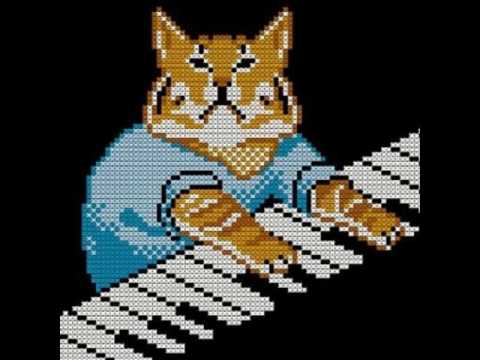

In [103]:
from IPython.display import YouTubeVideo
YouTubeVideo('1rZ9cqSJgRM')